# Modifying code from jgarci92 to aggregate classifications and eliminate outliers


Our goal here is to take the original python code and make it so that we can eliminate the bad classifications from Zooniverse users and only pass on good classification data to the machine learning algorithm.

## First import a bunch of modules to use:

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as col
from sklearn.cluster import DBSCAN
from sklearn import metrics
from matplotlib.patches import Ellipse
style.use('ggplot')

from itertools import filterfalse

import csv

from astropy.stats import circmean
from astropy import units as u

import matplotlib.cm as cm
import matplotlib.colors as col
cmap_1 = cm.ScalarMappable(col.Normalize(1, 11, cm.gist_rainbow))

## Open file and store in data:

In [187]:
# new-steelpan-vibrations-classifications.csv should be generated from csvcount routine
with open("new-steelpan-vibrations-classifications-061818.csv") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    data = [r for r in reader]

## This is the main data parsing routine:

In [188]:
allsubjectids = []
for i in range(len(data)):
    allsubjectids.append(int(data[i][13]))

#Remove duplicate subject_ids
uniquesubjectids = (set(allsubjectids))

# Initialize empty dictionary of our subjects to be checked
d = {}
# Fill dictionary with keys from uniquesubjectids
for k in uniquesubjectids:
    d['coords'+str(k)] = []


# Parse the raw classification data for the subjects to be checked    
for i in range(len(data)):
    parsed_json = json.loads(data[i][11])
    if data[i][5] != "Retirement Limit Test" and int(data[i][13]) in uniquesubjectids:
        if len(parsed_json)==2:
            for j in range(len(parsed_json[1]['value'])):
                if len(parsed_json[1]['value'][j]['details']) == 1:
                    if isinstance(parsed_json[1]['value'][j]['details'][0]['value'], str):
                        try:
                            fringe_count = int(parsed_json[1]['value'][j]['details'][0]['value'])
                        except ValueError:
                            pass

                    else:
                        fringe_count = parsed_json[1]['value'][j]['details'][0]['value']
                    
                    datalist = [parsed_json[1]['value'][j]['x'],parsed_json[1]['value'][j]['y'],data[i][13],fringe_count,parsed_json[1]['value'][j]['rx'],parsed_json[1]['value'][j]['ry'],parsed_json[1]['value'][j]['angle']]
                    
                    d['coords'+data[i][13]].append(datalist)
                    
        elif len(parsed_json)==1:
            # If there are no fringes recorded, fill every field except subject_id with 0 -> parse later
            datalist = [0,0,data[i][13],0,0,0,0]
            d['coords'+data[i][13]].append(datalist)
            #print(data[i][13]," No antinodes found!")
            
print(len(data))

3727


## Important functions

The functions dbscan, draw_ellipse, and df_to_center_plt were initially written by jgarci92 and are used for generating the plots for each subject.

In [150]:
def dbscan(crds):
    bad_xy = []  #might need to change this
    X = np.array(crds)
    db = DBSCAN(eps=18, min_samples=3).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)
        
        # These are the definitely "good" xy values.
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
        #print("\n Good? xy = ",xy)
        #print("X = ",X)
        # These are the "bad" xy values. Note that some maybe-bad and maybe-good are included here.
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=6)
        #print("\n Bad? xy = ",xy)
        bad_xy.append(xy)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.xlim(0, 512)
    plt.ylim(0, 384)
    
    return bad_xy

In [154]:
def draw_ellipse(ell):
    fig = plt.figure(0)
    ax = fig.add_subplot(111, aspect='equal')
    for e in ell:
        ax.add_artist(e)
        e.set_alpha(.3)
    ax.set_xlim(0, 512)
    ax.set_ylim(0, 384)
    plt.show()

In [189]:
def df_to_center_plt(coords_x):
    x_val = []
    y_val = []
    frng = []
    crds = []
    ell = []
    
    for centers in coords_x:
        # The IndexErrors *might* have been fixed, but this has not been checked yet.
        try:
            x_val.append(centers[0])
        except IndexError:
            pass
        try:
            y_val.append(centers[1])
        except IndexError:
            pass
        try:
            frng.append(centers[3])
        except IndexError:
            pass
        try:
            crds.append([centers[0], centers[1]])
        except IndexError:
            pass
        try:
            ell.append(Ellipse(xy=[centers[0], centers[1]], width=centers[4], height=centers[5], angle=centers[6]))
        except IndexError:
            pass
    centers_raw = {'XVal': x_val,
                   'YVal': y_val,
                   'Fringe': frng}
    
    centers_df = pd.DataFrame(centers_raw, columns=['XVal', 'YVal', 'Fringe'])
    plt.scatter(centers_df.XVal, centers_df.YVal, s=20, c=cmap_1.to_rgba(centers_df.Fringe), alpha=.6)
    plt.xlim(0, 512)
    plt.ylim(0, 384)
    plt.title('Subject id = %s'%(coords_x[0][2]))
    plt.show()
    bad_xy = dbscan(crds)
    #print("bad_xy = ",bad_xy)
    #for each in ell:
    #    print("ell.center = ",each.center)
    #    print("ell.angle = ",each.angle)
    #    print("ell.width = ",each.width)
    #    print("ell.height = ",each.height)
    draw_ellipse(ell)
    
    ###Filter out the bad_xy entries - we will only look at bad x coordinates and remove all entries matching the bad_x.
    ###There is probably a better way to do this, or at least do more cross checking.
    bad_x = 0
    new_coords_x = []
    keepgood = coords_x
    for i in range(len(bad_xy)):
        try:
            for j in range(len(bad_xy[i])):
                try:
                    
                    bad_x = bad_xy[i][j][0]
                    # bad_y is not (currently) being used.
                    bad_y = bad_xy[i][j][1]
                    #print("bad_x = ",bad_x)
                    # This list comprehension step is what removes the bad ellipse
                    keepgood = [item for item in keepgood if item[:][0] != bad_x]
                    
                except IndexError:
                    pass
                #if bad_x != coords_x[i][0]:
                #        print(coords_x[i])
            #if bad_x == coords_x[i][0]:
            #    print("Bad Entry!")
            #else:
            #    print(coords_x[i])
        except IndexError:
            pass
    averages = dbscan_average(keepgood)
    print("averages = ",averages)
    average_list = []
    print(len(averages[0]))
    for i in range(len(averages[0])):
        average_list.append([averages[0][i],averages[1][i],keepgood[0][2],averages[2][i],averages[3][i],averages[4][i],averages[5][i]])
        #print(averages[0][i])
        #print(averages[1][i])
        #print(averages[2][i])
        #print(averages[3][i])
        #print(averages[4][i])
        #print(averages[5][i])
    print("\n average_list = ",average_list)
    
    # DO THE ACTUAL WRITING TO THE FILE HERE!
    with open("average_all-good-ellipses-TEST-061818.csv", "a") as f:
        writer = csv.writer(f)
        writer.writerows(average_list)
    f.close
    
    #listresult = list(result)
    #print(listresult)
    #for each in result:
    #    print(each)
    #for k in coords_x:
    #    print("x = ",k[0])
    #thefile = open('test.csv', 'w')
    #for each in keepgood:
    #    print(each)
    #    thefile.write("%s\n" % each)
    print("\n keepgood = ",keepgood)
    # DO THE ACTUAL WRITING TO THE FILE HERE!
    #with open("all-good-ellipses.csv", "a") as f:
    #    writer = csv.writer(f)
    #    writer.writerows(keepgood)
    #f.close

## Test individual subject_ids:

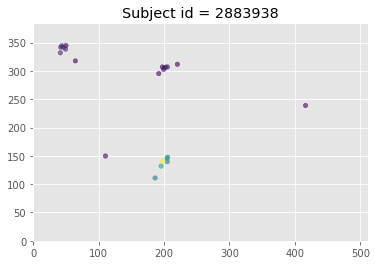

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


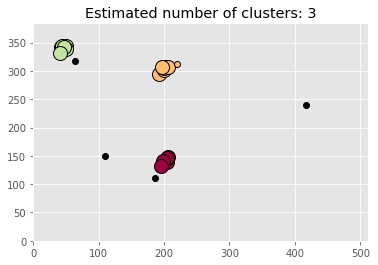

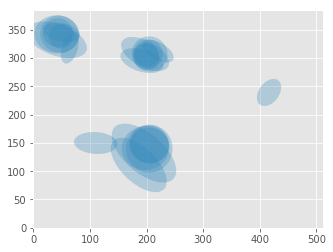

x_mean =  [201.64212646484376, 199.50643666585287, 45.355489095052086]
y_mean =  [141.13333435058593, 303.99862670898438, 340.58829243977863]
fringe_count_mean =  [7.0, 1.6666666666666667, 1.8333333333333333]
rx_mean =  [87.375732638106143, 63.315262664958631, 70.540055407739104]
ry_mean =  [73.791090994138841, 47.786447263303067, 52.398568812084818]
angle_mean =  [-31.70817270648596, -14.059960193834655, -4.27305089154436]
averages =  [[201.64212646484376, 199.50643666585287, 45.355489095052086], [141.13333435058593, 303.99862670898438, 340.58829243977863], [7.0, 1.6666666666666667, 1.8333333333333333], [87.375732638106143, 63.315262664958631, 70.540055407739104], [73.791090994138841, 47.786447263303067, 52.398568812084818], [-31.70817270648596, -14.059960193834655, -4.27305089154436]]
3

 average_list =  [[201.64212646484376, 141.13333435058593, '2883938', 7.0, 87.375732638106143, 73.791090994138841, -31.70817270648596], [199.50643666585287, 303.99862670898438, '2883938', 1.666666666

In [177]:
df_to_center_plt(d['coords2883938'])

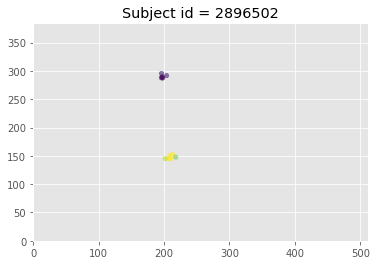

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


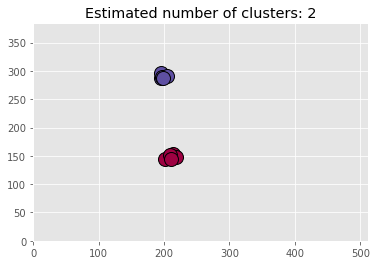

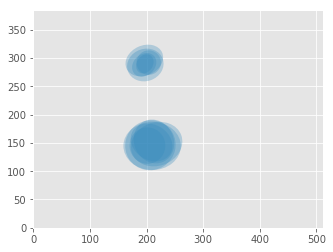

x_mean =  [209.6198705037435, 198.069091796875]
y_mean =  [147.73082224527994, 290.38917236328126]
fringe_count_mean =  [10.5, 1.6000000000000001]
rx_mean =  [84.165159634534362, 48.4560935207558]
ry_mean =  [74.115176239829282, 47.308440938447909]
angle_mean =  [159.46410059526912, -31.907351294039355]
averages =  [[209.6198705037435, 198.069091796875], [147.73082224527994, 290.38917236328126], [10.5, 1.6000000000000001], [84.165159634534362, 48.4560935207558], [74.115176239829282, 47.308440938447909], [159.46410059526912, -31.907351294039355]]
2
209.619870504
147.730822245
10.5
84.1651596345
74.1151762398
159.46410059526912
198.069091797
290.389172363
1.6
48.4560935208
47.3084409384
-31.907351294039355

 average_list =  []

 keepgood =  [[206.796875, 145.75, '2896502', 11, 89.80534505250787, 87.66413177577246, -147.57893523749306], [195.796875, 287.75, '2896502', 2, 37.33630940518894, 46.75467891024384, -48.46822925891715], [213, 152.46665954589844, '2896502', 11, 79.02531240052139, 

In [172]:
df_to_center_plt(d['coords2896502'])

coords_x =  [[155, 93.44999694824219, '2883463', 1, 44.181444068749045, 22.090722034374522, 95.1944289077348], [361, 163.4499969482422, '2883463', 1, 51.40038910358559, 25.700194551792794, -142.90716270295846], [0, 0, '2883463', 0, 0, 0, 0], [143.8125, 142.75, '2883463', 2, 301.59741378201505, 150.79870689100753, -28.51948999456811], [0, 0, '2883463', 0, 0, 0, 0], [0, 0, '2883463', 0, 0, 0, 0], [0, 0, '2883463', 0, 0, 0, 0], [0, 0, '2883463', 0, 0, 0, 0], [214.5, 151.96665954589844, '2883463', 2, 19.1049731745428, 21.02379604162864, -83.99099404250548], [0, 0, '2883463', 0, 0, 0, 0], [160.0364532470703, 142.834228515625, '2883463', 2, 44.73269155757933, 38.31170333505653, -113.72041773042523], [212.6490936279297, 153.46304321289062, '2883463', 5, 47.90344714726392, 53.13613141797525, -59.331083059182994], [0, 0, '2883463', 0, 0, 0, 0]]
centers_raw =  {'XVal': [155, 361, 0, 143.8125, 0, 0, 0, 0, 214.5, 0, 160.0364532470703, 212.6490936279297, 0], 'YVal': [93.44999694824219, 163.44999694

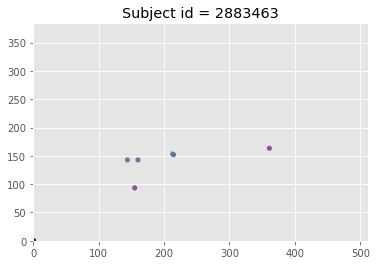


 labels =  [-1 -1  0 -1  0  0  0  0 -1  0 -1 -1  0] 


 unique_labels =  {0, -1} 


 xy =  [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]

 Bad? xy =  []

 xy =  []

 Bad? xy =  [[ 155.           93.44999695]
 [ 361.          163.44999695]
 [ 143.8125      142.75      ]
 [ 214.5         151.96665955]
 [ 160.03645325  142.83422852]
 [ 212.64909363  153.46304321]]


/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


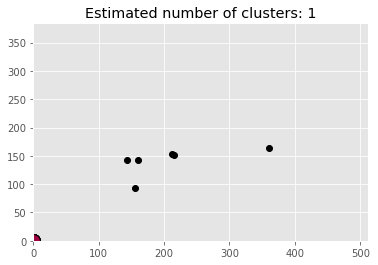

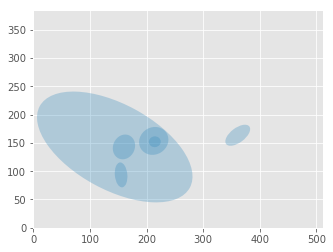

bad_xy =  None


In [10]:
df_to_center_plt(d['coords2883463'])

## Write a loop to iterate over all subject sets in the dictionary:

key = coords2883584 value =  [[397.296875, 157, '2883584', 10, 63.071388124885914, 41.19465984809196, 5.572197803963803], [212.796875, 143.75, '2883584', 4, 65.7419196555744, 61.587336360651285, 32.399840173919344], [209, 144.760009765625, '2883584', 1, 85.44003745317531, 42.720018726587654, -20.556045219583467], [23, 343.760009765625, '2883584', 1, 54.405882034941776, 27.202941017470888, 17.102728969052375], [203.796875, 139.75, '2883584', 7, 98.68130522039117, 49.34065261019558, 19.53665493812839], [214.6999969482422, 142.86666870117188, '2883584', 4, 55.036351623268054, 27.518175811634027, 65.2975697722287], [210.04782104492188, 138.72998046875, '2883584', 6, 74.6911181133972, 65.24596009347535, 26.02959443158207]] 



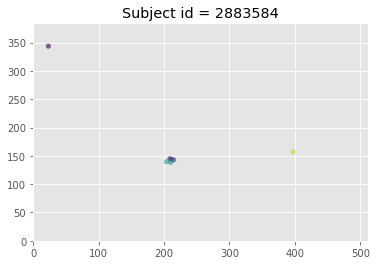

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


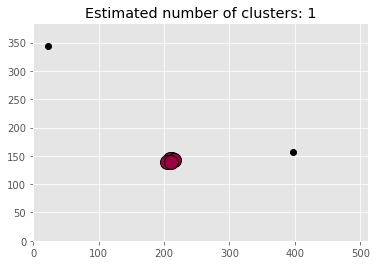

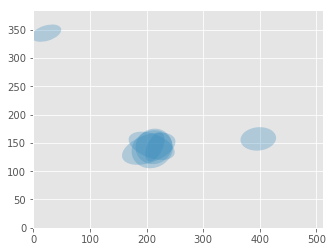

x_mean =  [210.06831359863281]
y_mean =  [141.97133178710936]
fringe_count_mean =  [4.4000000000000004]
rx_mean =  [75.918146413161224]
ry_mean =  [49.282428720508776]
angle_mean =  [24.798809172935123]
averages =  [[210.06831359863281], [141.97133178710936], [4.4000000000000004], [75.918146413161224], [49.282428720508776], [24.798809172935123]]
1

 average_list =  [[210.06831359863281, 141.97133178710936, '2883584', 4.4000000000000004, 75.918146413161224, 49.282428720508776, 24.798809172935123]]

 keepgood =  [[212.796875, 143.75, '2883584', 4, 65.7419196555744, 61.587336360651285, 32.399840173919344], [209, 144.760009765625, '2883584', 1, 85.44003745317531, 42.720018726587654, -20.556045219583467], [203.796875, 139.75, '2883584', 7, 98.68130522039117, 49.34065261019558, 19.53665493812839], [214.6999969482422, 142.86666870117188, '2883584', 4, 55.036351623268054, 27.518175811634027, 65.2975697722287], [210.04782104492188, 138.72998046875, '2883584', 6, 74.6911181133972, 65.24596009347

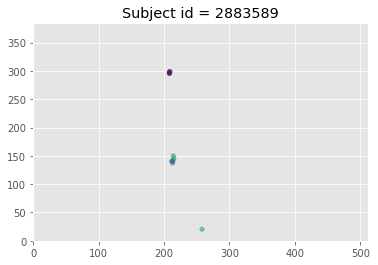

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


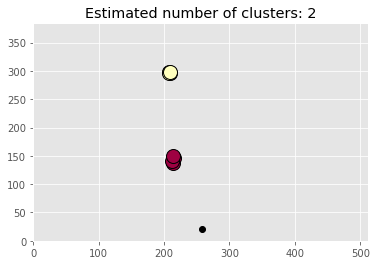

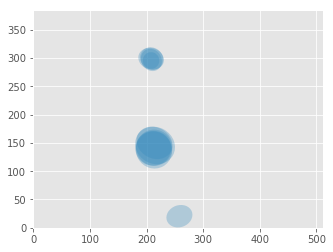

x_mean =  [213.46392211914062, 208.36112594604492]
y_mean =  [142.96793518066406, 297.34445190429688]
fringe_count_mean =  [5.2000000000000002, 1.5]
rx_mean =  [64.406624762489088, 39.599650647564118]
ry_mean =  [63.436378452701561, 35.182005133712913]
angle_mean =  [-39.08829024187007, -44.88528553520724]
averages =  [[213.46392211914062, 208.36112594604492], [142.96793518066406, 297.34445190429688], [5.2000000000000002, 1.5], [64.406624762489088, 39.599650647564118], [63.436378452701561, 35.182005133712913], [-39.08829024187007, -44.88528553520724]]
2

 average_list =  [[213.46392211914062, 142.96793518066406, '2883589', 5.2000000000000002, 64.406624762489088, 63.436378452701561, -39.08829024187007], [208.36112594604492, 297.34445190429688, '2883589', 1.5, 39.599650647564118, 35.182005133712913, -44.88528553520724]]

 keepgood =  [[213.5, 141.46665954589844, '2883589', 3, 64.20280367709809, 63.655321851358195, -46.27303002005671], [208.5, 296.4666748046875, '2883589', 1, 40.804411526

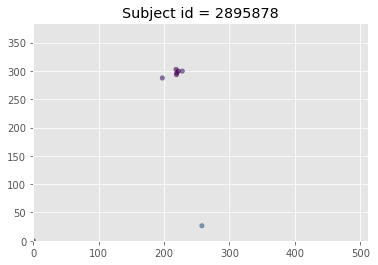

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


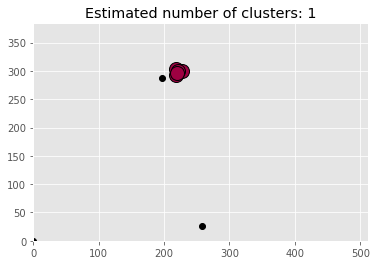

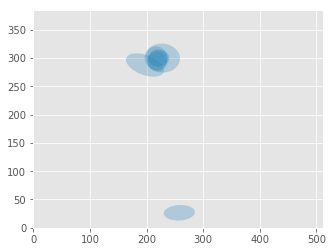

x_mean =  [221.24308471679689]
y_mean =  [298.39683227539064]
fringe_count_mean =  [1.0]
rx_mean =  [41.464663539485535]
ry_mean =  [37.390900045067212]
angle_mean =  [-13.14525717183081]
averages =  [[221.24308471679689], [298.39683227539064], [1.0], [41.464663539485535], [37.390900045067212], [-13.14525717183081]]
1

 average_list =  [[221.24308471679689, 298.39683227539064, '2895878', 1.0, 41.464663539485535, 37.390900045067212, -13.14525717183081]]

 keepgood =  [[218.84564208984375, 293.3800048828125, '2895878', 0, 34.165150741096404, 34.438599037689954, 12.74567797981824], [218.296875, 302.75, '2895878', 1, 38.27531841800928, 34.132096331752024, -31.827446576673104], [227.796875, 299.75, '2895878', 2, 62.51399843235114, 51.15662224971465, -4.4846060095446205], [221.796875, 299.5, '2895878', 1, 37.013511046643494, 29.017236257093817, 1.9749340108819808], [219.47915649414062, 296.6041564941406, '2895878', 1, 35.35533905932738, 38.2099463490856, -45]]
key = coords2883590 value =  [[

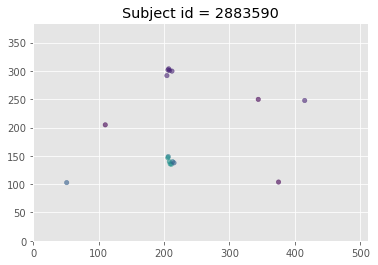

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


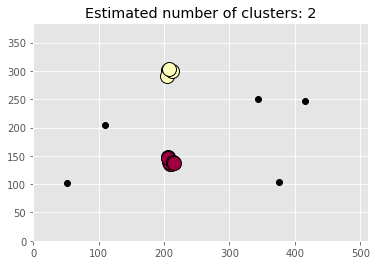

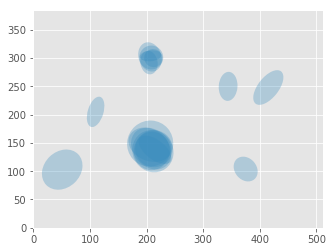

x_mean =  [209.80887930733817, 207.53875427246095]
y_mean =  [140.52765546526228, 299.52999877929688]
fringe_count_mean =  [5.4285714285714288, 2.0]
rx_mean =  [73.959606756476504, 41.570844254932311]
ry_mean =  [62.40087889841692, 32.709026634414769]
angle_mean =  [-118.18089318238201, -47.09722839666248]
averages =  [[209.80887930733817, 207.53875427246095], [140.52765546526228, 299.52999877929688], [5.4285714285714288, 2.0], [73.959606756476504, 41.570844254932311], [62.40087889841692, 32.709026634414769], [-118.18089318238201, -47.09722839666248]]
2

 average_list =  [[209.80887930733817, 140.52765546526228, '2883590', 5.4285714285714288, 73.959606756476504, 62.40087889841692, -118.18089318238201], [207.53875427246095, 299.52999877929688, '2883590', 2.0, 41.570844254932311, 32.709026634414769, -47.09722839666248]]

 keepgood =  [[211.1558837890625, 135.2935791015625, '2883590', 6, 76.21667064500113, 71.11421451521481, -234.4623150623972], [206.3125, 148.75, '2883590', 5, 80.8084154

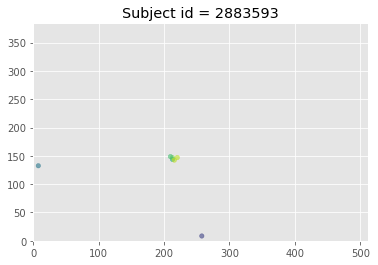

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


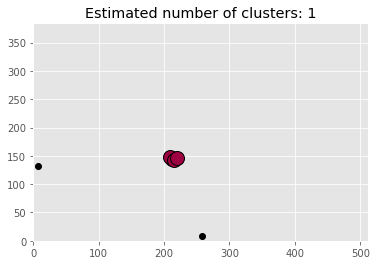

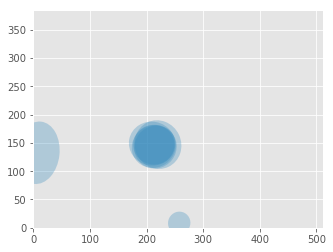

x_mean =  [214.20726623535157]
y_mean =  [145.72929077148439]
fringe_count_mean =  [8.8000000000000007]
rx_mean =  [78.542553592639521]
ry_mean =  [76.711407143960699]
angle_mean =  [-35.97127900703827]
averages =  [[214.20726623535157], [145.72929077148439], [8.8000000000000007], [78.542553592639521], [76.711407143960699], [-35.97127900703827]]
1

 average_list =  [[214.20726623535157, 145.72929077148439, '2883593', 8.8000000000000007, 78.542553592639521, 76.711407143960699, -35.97127900703827]]

 keepgood =  [[212.796875, 143.75, '2883593', 7, 79.40403012442127, 74.33034373659252, 33.47627829610266], [212.796875, 146.75, '2883593', 9, 70.34912934784623, 73.06161783043132, -92.35329686610831], [209.6999969482422, 148.6999969482422, '2883593', 8, 82.09748776642819, 77.46612162745726, -11.164880177548582], [215.63540649414062, 142.5, '2883593', 10, 74.02702209328699, 76.83749084919418, -38.418055344821994], [220.107177734375, 146.9464569091797, '2883593', 10, 86.83509863121498, 81.86146

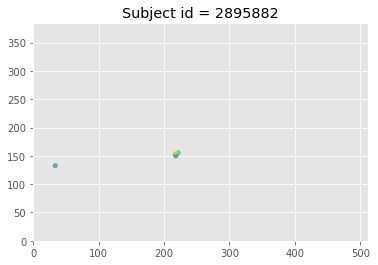

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


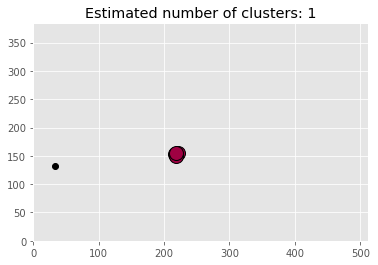

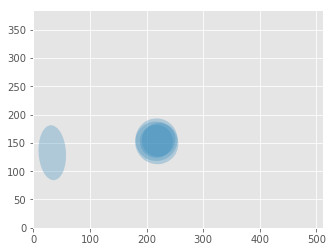

x_mean =  [218.52640533447266]
y_mean =  [153.39651107788086]
fringe_count_mean =  [7.25]
rx_mean =  [67.71383023329129]
ry_mean =  [66.412650980898789]
angle_mean =  [11.105745294121327]
averages =  [[218.52640533447266], [153.39651107788086], [7.25], [67.71383023329129], [66.412650980898789], [11.105745294121327]]
1

 average_list =  [[218.52640533447266, 153.39651107788086, '2895882', 7.25, 67.71383023329129, 66.412650980898789, 11.105745294121327]]

 keepgood =  [[217.296875, 152.75, '2895882', 5, 58.05170109479997, 58.25804665451803, -50.572197803963796], [221.33999633789062, 155.260009765625, '2895882', 7, 60.37383539249432, 58.52349955359813, 56.85300416774399], [218, 149.96665954589844, '2895882', 6, 77.10382610480494, 74.4043009509531, -36.25383773744479], [217.46875, 155.609375, '2895882', 11, 75.32595834106593, 74.46475676452586, 75.21727395738432]]
key = coords2895884 value =  [[216.296875, 152.75, '2895884', 11, 63.56099432828282, 67.7421582177598, -8.488943880504706], [24

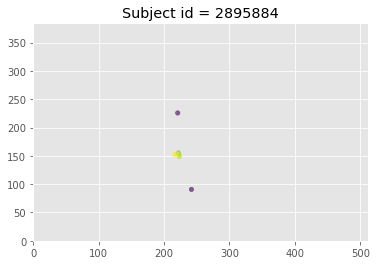

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


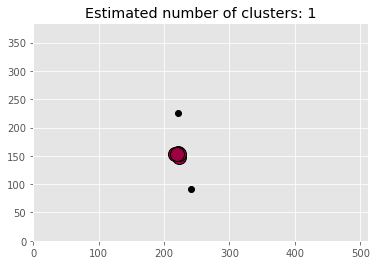

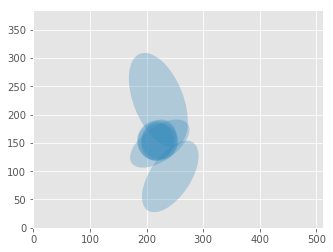

x_mean =  [220.71273498535157]
y_mean =  [152.62583312988281]
fringe_count_mean =  [10.0]
rx_mean =  [75.646584137495623]
ry_mean =  [67.835511400495264]
angle_mean =  [-43.233236206452204]
averages =  [[220.71273498535157], [152.62583312988281], [10.0], [75.646584137495623], [67.835511400495264], [-43.233236206452204]]
1

 average_list =  [[220.71273498535157, 152.62583312988281, '2895884', 10.0, 75.646584137495623, 67.835511400495264, -43.233236206452204]]

 keepgood =  [[216.296875, 152.75, '2895884', 11, 63.56099432828282, 67.7421582177598, -8.488943880504706], [223.296875, 148.75, '2895884', 10, 120.6731121667126, 60.3365560833563, -145.12467165539783], [221.6999969482422, 155.14999389648438, '2895884', 8, 59.93328250689273, 74.32360972397937, -23.805945892455625], [222.76992797851562, 152.7291717529297, '2895884', 10, 62.476426369208205, 64.325250230661, 51.76617288148793], [219.5, 153.75, '2895884', 11, 71.58910531638176, 72.44998274671983, -110.18580300946485]]
key = coords2895

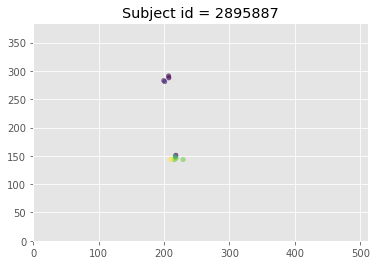

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


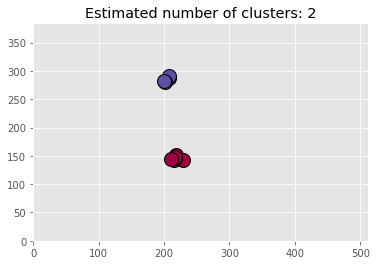

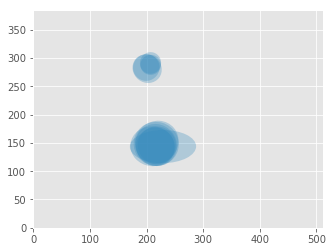

x_mean =  [217.91338239397322, 203.67473602294922]
y_mean =  [145.97949000767298, 285.71665954589844]
fringe_count_mean =  [8.0, 1.5]
rx_mean =  [80.605547281676891, 43.501736093659041]
ry_mean =  [69.730001534478077, 42.419688238910901]
angle_mean =  [-30.764798597840095, 60.50817675377551]
averages =  [[217.91338239397322, 203.67473602294922], [145.97949000767298, 285.71665954589844], [8.0, 1.5], [80.605547281676891, 43.501736093659041], [69.730001534478077, 42.419688238910901], [-30.764798597840095, 60.50817675377551]]
2

 average_list =  [[217.91338239397322, 145.97949000767298, '2895887', 8.0, 80.605547281676891, 69.730001534478077, -30.764798597840095], [203.67473602294922, 285.71665954589844, '2895887', 1.5, 43.501736093659041, 42.419688238910901, 60.50817675377551]]

 keepgood =  [[218.296875, 145.75, '2895887', 9, 67.67569726275453, 66.70832032063167, -23.875280853927507], [207.296875, 287.75, '2895887', 1, 35.4682957019364, 36.49657518178932, -260.5376777919744], [206.9333190

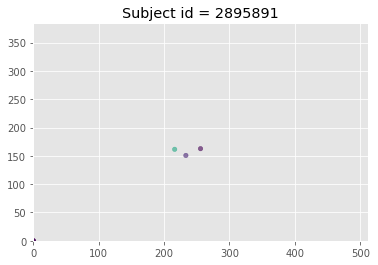

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


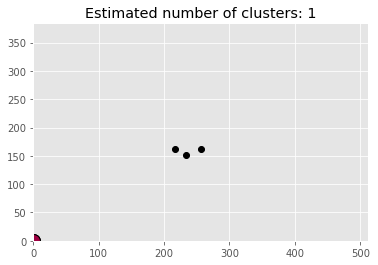

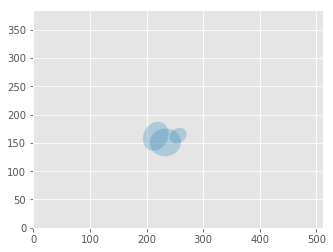

x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '2895891', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '2895891', 0, 0, 0, 0], [0, 0, '2895891', 0, 0, 0, 0], [0, 0, '2895891', 0, 0, 0, 0]]
key = coords2895892 value =  [[509.796875, 105.75, '2895892', 1, 291.66076184499, 145.830380922495, -106.94385527120905], [18.796875, 23.75, '2895892', 1, 388.9884317045945, 194.49421585229726, -59.743562836470744], [0, 0, '2895892', 0, 0, 0, 0], [0, 0, '2895892', 0, 0, 0, 0], [0, 0, '2895892', 0, 0, 0, 0], [0, 0, '2895892', 0, 0, 0, 0], [0, 0, '2895892', 0, 0, 0, 0], [0, 0, '2895892', 0, 0, 0, 0]] 



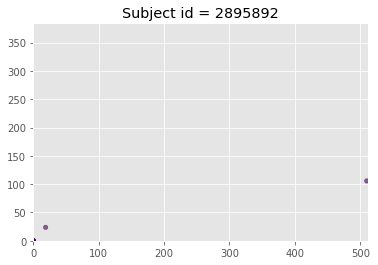

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


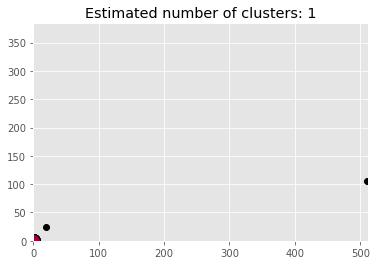

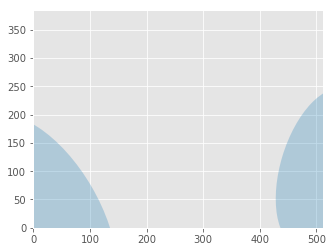

x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '2895892', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '2895892', 0, 0, 0, 0], [0, 0, '2895892', 0, 0, 0, 0], [0, 0, '2895892', 0, 0, 0, 0], [0, 0, '2895892', 0, 0, 0, 0], [0, 0, '2895892', 0, 0, 0, 0], [0, 0, '2895892', 0, 0, 0, 0]]
key = coords2906131 value =  [[0, 0, '2906131', 0, 0, 0, 0], [273.796875, 104.75, '2906131', 1, 42.720018726587654, 31.32091952673165, -16.69924423399361], [121.796875, 109.75, '2906131', 10, 96.15092303249095, 95.46203433826454, -67.19545952867895], [119.45940399169922, 132.52859497070312, '2906131', 11, 67.92855529785218, 57.65526355821328, -235.56103391643796], [121.0999984741211, 101.1500015258789, '2906131', 8, 117.92370076760793, 102.08330137498842, 57.3996646225788], [0, 0, '2906131', 0, 0, 0, 0], [114.88333129882812, 124.58332824707031, '2906131', 1, 87

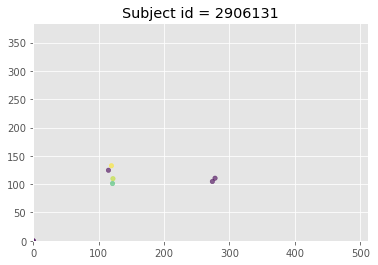

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


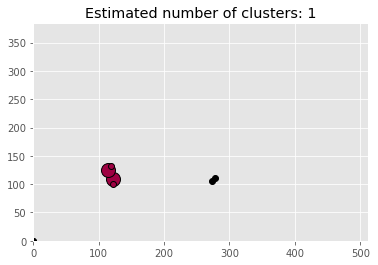

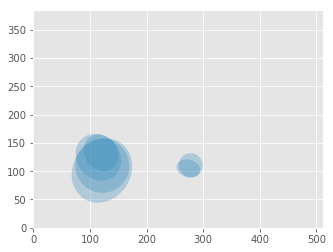

x_mean =  [nan]
y_mean =  [nan]
fringe_count_mean =  [nan]
rx_mean =  [nan]
ry_mean =  [nan]
angle_mean =  [nan]
averages =  [[nan], [nan], [nan], [nan], [nan], [nan]]
1

 average_list =  [[nan, nan, '2906131', nan, nan, nan, nan]]

 keepgood =  [[121.796875, 109.75, '2906131', 10, 96.15092303249095, 95.46203433826454, -67.19545952867895], [114.88333129882812, 124.58332824707031, '2906131', 1, 87.32124598286491, 75.16648189186454, -229.31602751986563]]
key = coords2906132 value =  [[112.796875, 115.75, '2906132', 8, 82.49242389456137, 77.23341245859851, 96.26349061433454], [112.296875, 101.75, '2906132', 10, 92.65527507918802, 72.40338389882064, -71.76059915334885], [115.796875, 114.5, '2906132', 10, 89.8276126811795, 83.86894538504703, -140.80672690553158], [110.796875, 116.5, '2906132', 11, 98.79271228182775, 79.12016177940993, -249.27444113443946], [0, 0, '2906132', 0, 0, 0, 0], [106.96875, 107, '2906132', 1, 104.6900186264192, 91.6624241442479, -96.58194465517802]] 



/Users/amorriso/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/amorriso/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/amorriso/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:951: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


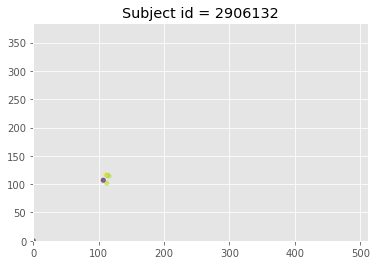

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


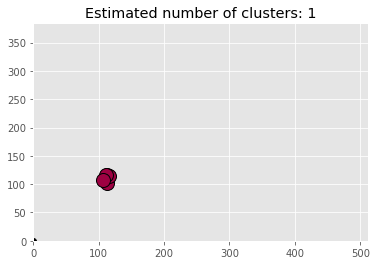

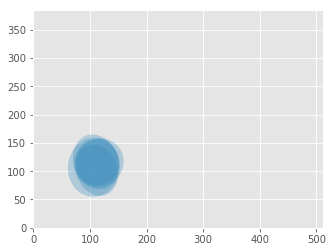

x_mean =  [111.73125]
y_mean =  [111.09999999999999]
fringe_count_mean =  [8.0]
rx_mean =  [93.691608512635156]
ry_mean =  [80.857665533224804]
angle_mean =  [-148.15311188914666]
averages =  [[111.73125], [111.09999999999999], [8.0], [93.691608512635156], [80.857665533224804], [-148.15311188914666]]
1

 average_list =  [[111.73125, 111.09999999999999, '2906132', 8.0, 93.691608512635156, 80.857665533224804, -148.15311188914666]]

 keepgood =  [[112.796875, 115.75, '2906132', 8, 82.49242389456137, 77.23341245859851, 96.26349061433454], [112.296875, 101.75, '2906132', 10, 92.65527507918802, 72.40338389882064, -71.76059915334885], [115.796875, 114.5, '2906132', 10, 89.8276126811795, 83.86894538504703, -140.80672690553158], [110.796875, 116.5, '2906132', 11, 98.79271228182775, 79.12016177940993, -249.27444113443946], [106.96875, 107, '2906132', 1, 104.6900186264192, 91.6624241442479, -96.58194465517802]]
key = coords2895898 value =  [[199.85313415527344, 149.41551208496094, '2895898', 6, 7

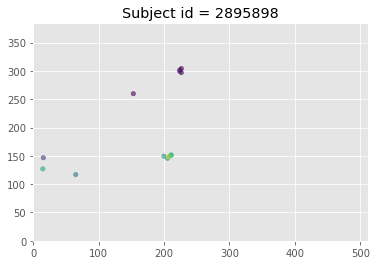

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


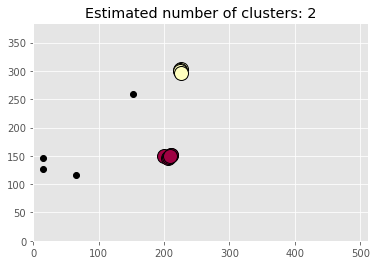

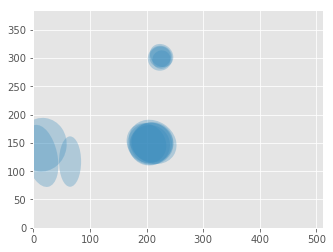

x_mean =  [206.95729319254556, 225.148681640625]
y_mean =  [149.23203023274741, 300.62750244140625]
fringe_count_mean =  [7.833333333333333, 1.0]
rx_mean =  [76.632908957735935, 38.965743523577871]
ry_mean =  [72.121945249469604, 38.432798818859169]
angle_mean =  [143.6962974319654, 42.31154422018055]
averages =  [[206.95729319254556, 225.148681640625], [149.23203023274741, 300.62750244140625], [7.833333333333333, 1.0], [76.632908957735935, 38.965743523577871], [72.121945249469604, 38.432798818859169], [143.6962974319654, 42.31154422018055]]
2

 average_list =  [[206.95729319254556, 149.23203023274741, '2895898', 7.833333333333333, 76.632908957735935, 72.121945249469604, 143.6962974319654], [225.148681640625, 300.62750244140625, '2895898', 1.0, 38.965743523577871, 38.432798818859169, 42.31154422018055]]

 keepgood =  [[199.85313415527344, 149.41551208496094, '2895898', 6, 74.77733427513385, 65.56480038690566, -45.54833148314019], [226.5009765625, 304.25, '2895898', 0, 44.06917682950097

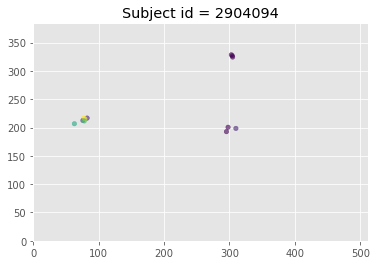

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


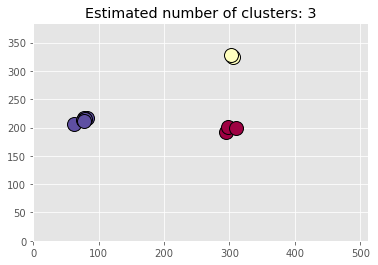

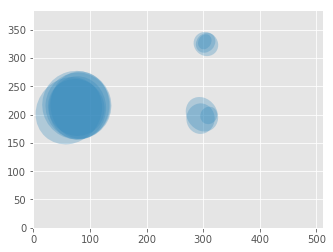

x_mean =  [300.96468098958331, 303.96485392252606, 75.739756266276046]
y_mean =  [197.25543721516928, 326.59213256835938, 213.27116394042969]
fringe_count_mean =  [1.3333333333333333, 1.0, 7.0]
rx_mean =  [47.756745221753427, 33.694407425416813, 111.4726303701064]
ry_mean =  [46.439459069742263, 34.820554392337904, 113.16418393987333]
angle_mean =  [-31.07726771383538, -30.765165487361163, -83.17104313064785]
averages =  [[300.96468098958331, 303.96485392252606, 75.739756266276046], [197.25543721516928, 326.59213256835938, 213.27116394042969], [1.3333333333333333, 1.0, 7.0], [47.756745221753427, 33.694407425416813, 111.4726303701064], [46.439459069742263, 34.820554392337904, 113.16418393987333], [-31.07726771383538, -30.765165487361163, -83.17104313064785]]
3

 average_list =  [[300.96468098958331, 197.25543721516928, '2904094', 1.3333333333333333, 47.756745221753427, 46.439459069742263, -31.07726771383538], [303.96485392252606, 326.59213256835938, '2904094', 1.0, 33.694407425416813, 3

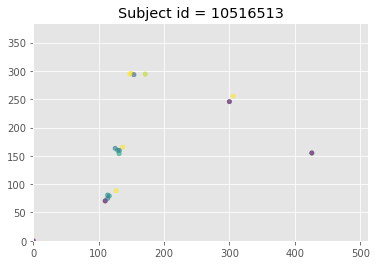

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


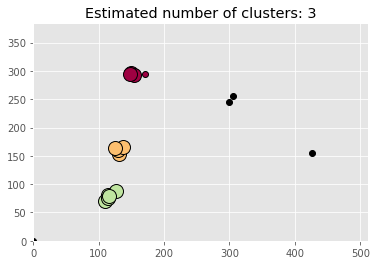

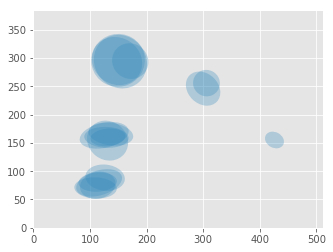

x_mean =  [150.39762369791666, 130.78025665283204, 116.05855636596679]
y_mean =  [294.56502278645831, 160.4396957397461, 78.823315429687497]
fringe_count_mean =  [8.6666666666666661, 6.7999999999999998, 5.7999999999999998]
rx_mean =  [94.109808843707853, 76.764959010468743, 71.985665559161987]
ry_mean =  [89.142609035962892, 43.951668361848149, 41.8193280957518]
angle_mean =  [-86.98763667014804, -8.600279877842526, 10.846642015347795]
averages =  [[150.39762369791666, 130.78025665283204, 116.05855636596679], [294.56502278645831, 160.4396957397461, 78.823315429687497], [8.6666666666666661, 6.7999999999999998, 5.7999999999999998], [94.109808843707853, 76.764959010468743, 71.985665559161987], [89.142609035962892, 43.951668361848149, 41.8193280957518], [-86.98763667014804, -8.600279877842526, 10.846642015347795]]
3

 average_list =  [[150.39762369791666, 294.56502278645831, '10516513', 8.6666666666666661, 94.109808843707853, 89.142609035962892, -86.98763667014804], [130.78025665283204, 16

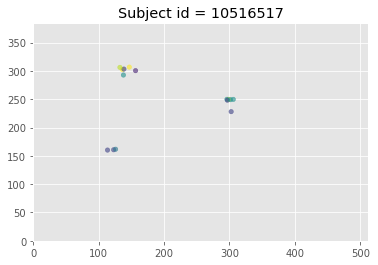

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


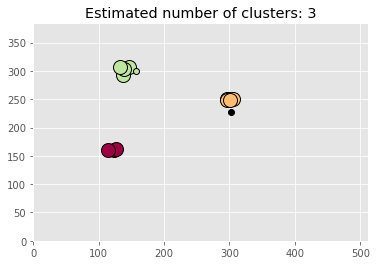

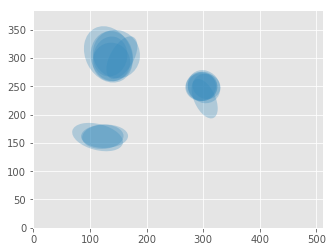

x_mean =  [120.6875, 299.79490356445314, 138.31398468017579]
y_mean =  [160.91666666666666, 249.38680114746094, 302.30518493652346]
fringe_count_mean =  [3.6666666666666665, 6.2000000000000002, 8.1999999999999993]
rx_mean =  [72.627789540622928, 52.905775906796897, 81.529505196364212]
ry_mean =  [53.524819873918943, 51.785071738974509, 74.903165850728527]
angle_mean =  [96.69679686321199, 83.06271950726519, -60.00493411950307]
averages =  [[120.6875, 299.79490356445314, 138.31398468017579], [160.91666666666666, 249.38680114746094, 302.30518493652346], [3.6666666666666665, 6.2000000000000002, 8.1999999999999993], [72.627789540622928, 52.905775906796897, 81.529505196364212], [53.524819873918943, 51.785071738974509, 74.903165850728527], [96.69679686321199, 83.06271950726519, -60.00493411950307]]
3

 average_list =  [[120.6875, 160.91666666666666, '10516517', 3.6666666666666665, 72.627789540622928, 53.524819873918943, 96.69679686321199], [299.79490356445314, 249.38680114746094, '10516517',

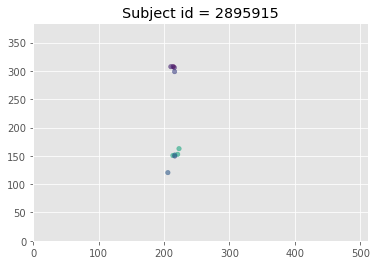

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


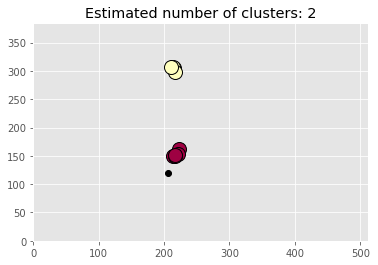

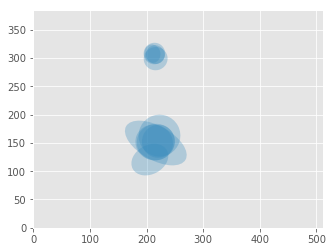

x_mean =  [217.92990417480468, 213.93627548217773]
y_mean =  [153.47163696289061, 304.94990539550781]
fringe_count_mean =  [5.7999999999999998, 2.0]
rx_mean =  [77.517195829188395, 35.212215123077328]
ry_mean =  [63.724426155211177, 36.395955317346619]
angle_mean =  [18.221588250648686, -37.83458419537207]
averages =  [[217.92990417480468, 213.93627548217773], [153.47163696289061, 304.94990539550781], [5.7999999999999998, 2.0], [77.517195829188395, 35.212215123077328], [63.724426155211177, 36.395955317346619], [18.221588250648686, -37.83458419537207]]
2

 average_list =  [[217.92990417480468, 153.47163696289061, '2895915', 5.7999999999999998, 77.517195829188395, 63.724426155211177, 18.221588250648686], [213.93627548217773, 304.94990539550781, '2895915', 2.0, 35.212215123077328, 36.395955317346619, -37.83458419537207]]

 keepgood =  [[213.44639587402344, 150.60818481445312, '2895915', 7, 66.9301304933792, 62.89139630924118, -21.25050802634742], [215.61732482910156, 305.82958984375, '289

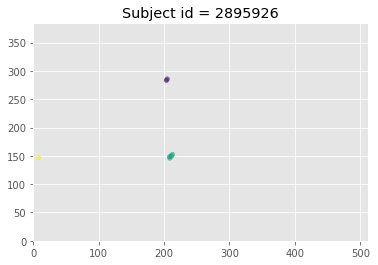

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


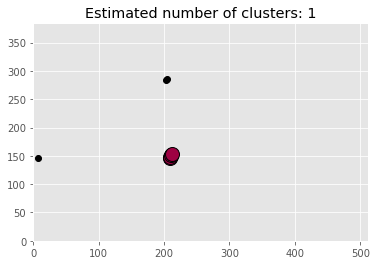

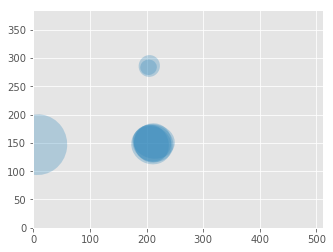

x_mean =  [210.41580505371093]
y_mean =  [149.36077575683595]
fringe_count_mean =  [7.0]
rx_mean =  [70.852668290187566]
ry_mean =  [64.218326048312704]
angle_mean =  [-80.47625246239294]
averages =  [[210.41580505371093], [149.36077575683595], [7.0], [70.852668290187566], [64.218326048312704], [-80.47625246239294]]
1

 average_list =  [[210.41580505371093, 149.36077575683595, '2895926', 7.0, 70.852668290187566, 64.218326048312704, -80.47625246239294]]

 keepgood =  [[211.2852783203125, 149.13722229003906, '2895926', 8, 73.4261412571955, 64.76403993316771, 160.3170107884738], [208.6999969482422, 145.9499969482422, '2895926', 7, 72.80111314530531, 66.64082832618455, -25.79602649449994], [208.5, 148.46665954589844, '2895926', 6, 68.15423684555495, 60.53924347066124, -67.57413807864822], [210.796875, 150.75, '2895926', 7, 65.55150646628954, 68.47627326307996, -28.81079374297307], [212.796875, 152.5, '2895926', 7, 74.33034373659252, 60.67124524847005, -188.53076560994813]]
key = coords2895

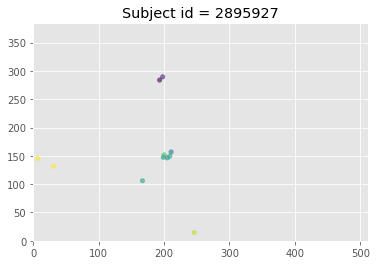

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


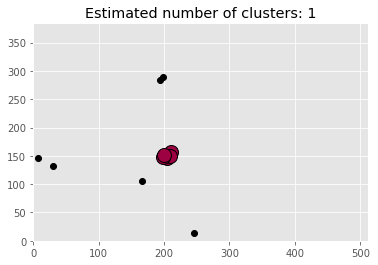

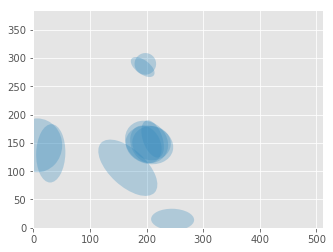

x_mean =  [204.65249938964843]
y_mean =  [150.38854064941407]
fringe_count_mean =  [6.4000000000000004]
rx_mean =  [74.522412581292571]
ry_mean =  [56.706631677012638]
angle_mean =  [22.56737338354923]
averages =  [[204.65249938964843], [150.38854064941407], [6.4000000000000004], [74.522412581292571], [56.706631677012638], [22.56737338354923]]
1

 average_list =  [[204.65249938964843, 150.38854064941407, '2895927', 6.4000000000000004, 74.522412581292571, 56.706631677012638, 22.56737338354923]]

 keepgood =  [[205, 146.46665954589844, '2895927', 6, 85.16454661418682, 67.1863081289633, -14.656751115760414], [210.6999969482422, 156.86666870117188, '2895927', 5, 68.9492567037528, 34.4746283518764, 109.48612957246577], [208.796875, 149.5, '2895927', 7, 68.24954212300622, 60.40695324215582, -6.654425046006594], [198.796875, 147.5, '2895927', 6, 69.52697318307479, 51.42956348249516, -243.434948822922], [199.96875, 151.609375, '2895927', 8, 80.72174428244226, 70.03570517957252, -41.98721249581

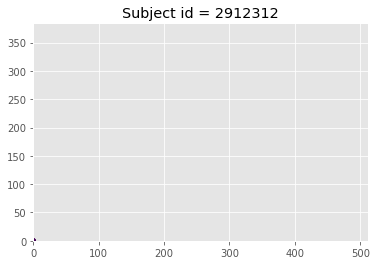

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


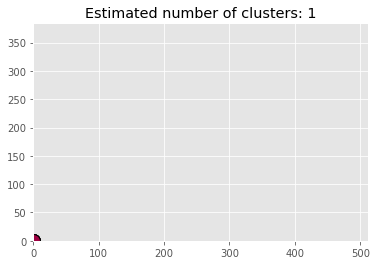

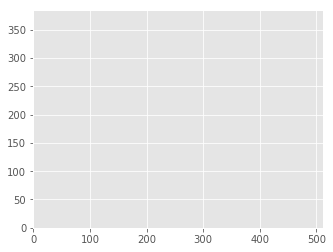

x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '2912312', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '2912312', 0, 0, 0, 0], [0, 0, '2912312', 0, 0, 0, 0], [0, 0, '2912312', 0, 0, 0, 0], [0, 0, '2912312', 0, 0, 0, 0], [0, 0, '2912312', 0, 0, 0, 0], [0, 0, '2912312', 0, 0, 0, 0]]
key = coords2912313 value =  [[0, 0, '2912313', 0, 0, 0, 0], [0, 0, '2912313', 0, 0, 0, 0], [0, 0, '2912313', 0, 0, 0, 0], [0, 0, '2912313', 0, 0, 0, 0], [0, 0, '2912313', 0, 0, 0, 0], [0, 0, '2912313', 0, 0, 0, 0]] 



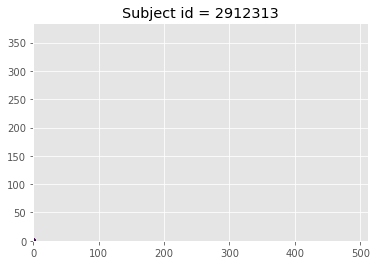

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


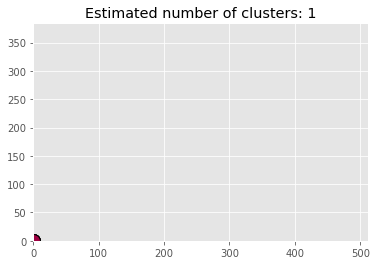

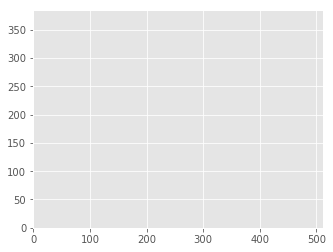

x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '2912313', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '2912313', 0, 0, 0, 0], [0, 0, '2912313', 0, 0, 0, 0], [0, 0, '2912313', 0, 0, 0, 0], [0, 0, '2912313', 0, 0, 0, 0], [0, 0, '2912313', 0, 0, 0, 0], [0, 0, '2912313', 0, 0, 0, 0]]
key = coords2895936 value =  [[226.296875, 152, '2895936', 2, 75.21303078589507, 58.4144673860851, -54.40531150095689], [222.296875, 302, '2895936', 1, 64.66065264130884, 32.33032632065442, -50.648247373735266], [218.296875, 303, '2895936', 0, 29, 26.800186566514792, -53.343891584033095], [231.796875, 158, '2895936', 1, 47.74149138851865, 46.010868281309364, -42.357454705935275], [232, 156.46665954589844, '2895936', 1, 67.20119046564577, 59.81638571495272, -38.21102542556121], [220, 305.4666748046875, '2895936', 2, 48.02082881417188, 47.4236228055175, -42.43622

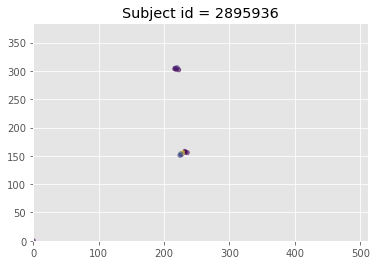

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


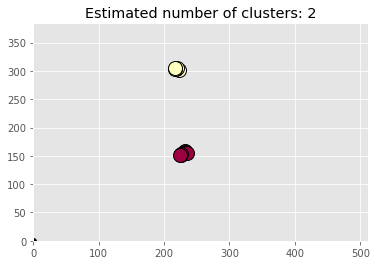

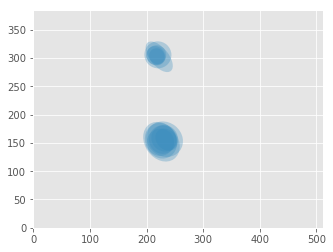

x_mean =  [229.06919642857142, 218.83750000000001]
y_mean =  [154.67380850655692, 303.84333496093751]
fringe_count_mean =  [3.2857142857142856, 1.2]
rx_mean =  [56.573283416746506, 42.361044811948808]
ry_mean =  [50.159218912623537, 34.813351799267942]
angle_mean =  [-54.31100121639805, -50.09120286793749]
averages =  [[229.06919642857142, 218.83750000000001], [154.67380850655692, 303.84333496093751], [3.2857142857142856, 1.2], [56.573283416746506, 42.361044811948808], [50.159218912623537, 34.813351799267942], [-54.31100121639805, -50.09120286793749]]
2

 average_list =  [[229.06919642857142, 154.67380850655692, '2895936', 3.2857142857142856, 56.573283416746506, 50.159218912623537, -54.31100121639805], [218.83750000000001, 303.84333496093751, '2895936', 1.2, 42.361044811948808, 34.813351799267942, -50.09120286793749]]

 keepgood =  [[226.296875, 152, '2895936', 2, 75.21303078589507, 58.4144673860851, -54.40531150095689], [222.296875, 302, '2895936', 1, 64.66065264130884, 32.33032632065

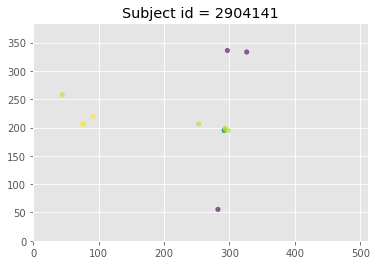

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


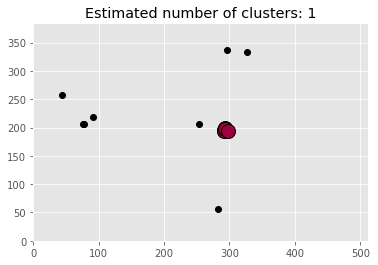

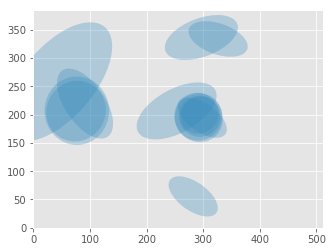

x_mean =  [293.84212646484377]
y_mean =  [196.18333435058594]
fringe_count_mean =  [8.5999999999999996]
rx_mean =  [82.384228884013098]
ry_mean =  [71.545836232061276]
angle_mean =  [-22.95184923424203]
averages =  [[293.84212646484377], [196.18333435058594], [8.5999999999999996], [82.384228884013098], [71.545836232061276], [-22.95184923424203]]
1

 average_list =  [[293.84212646484377, 196.18333435058594, '2904141', 8.5999999999999996, 82.384228884013098, 71.545836232061276, -22.95184923424203]]

 keepgood =  [[291.796875, 195.75, '2904141', 8, 85.0411665018772, 82.73451516749222, 44.5103044068708], [291.796875, 194.75, '2904141', 5, 89.40357934669059, 83.20006009613215, -53.642802580004535], [293.5, 198.96665954589844, '2904141', 10, 63.60031446463138, 68.8839603971781, -50.300926516525685], [293.796875, 197, '2904141', 10, 73.43704787094863, 72.69112738154499, -7.907162702958459], [298.32000732421875, 194.45001220703125, '2904141', 10, 100.43903623591775, 50.21951811795888, -35.2724

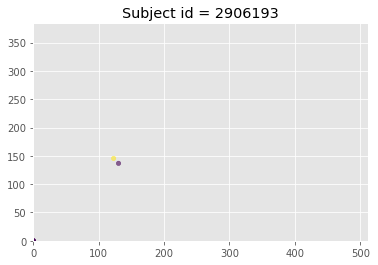

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


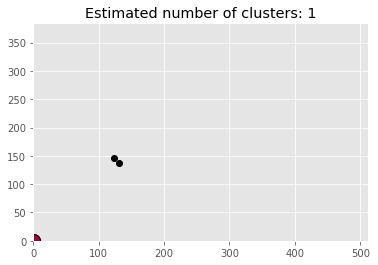

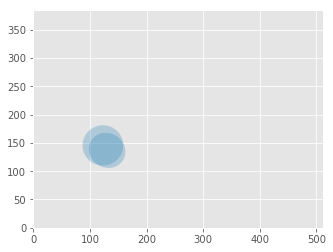

x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '2906193', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '2906193', 0, 0, 0, 0], [0, 0, '2906193', 0, 0, 0, 0], [0, 0, '2906193', 0, 0, 0, 0], [0, 0, '2906193', 0, 0, 0, 0]]
key = coords2895957 value =  [[206.4237823486328, 152.00619506835938, '2895957', 6, 74.03004140617934, 78.4123816571378, -232.25319916303658], [209.8125, 152, '2895957', 7, 84.30895563343196, 65, -202.61986494804043], [203.796875, 145.75, '2895957', 6, 75.23961722390672, 58.66856057549052, -29.623748751173814], [206.5, 142.4666748046875, '2895957', 6, 81.83520025025906, 89.18520287574258, -72.37769809994272], [212.5, 148.46665954589844, '2895957', 1, 62.03224967708329, 63.89053137985315, -17.300527191945008], [211.796875, 152.75, '2895957', 9, 68.26419266350405, 70.83078426785913, -149.45242825109298]] 



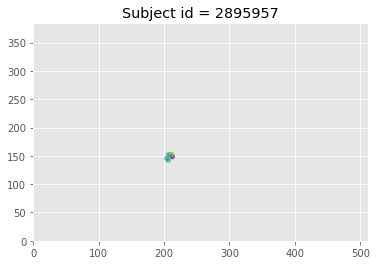

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


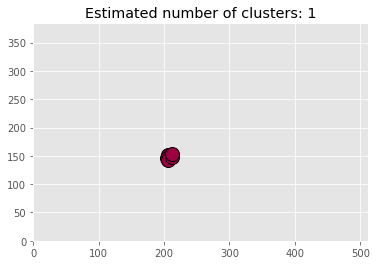

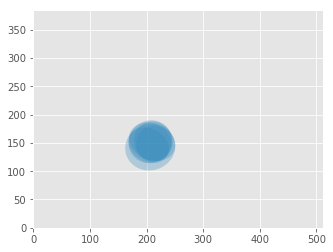

x_mean =  [208.47167205810547]
y_mean =  [148.90658823649088]
fringe_count_mean =  [5.833333333333333]
rx_mean =  [74.285042809060741]
ry_mean =  [70.997910126013863]
angle_mean =  [-104.04875935825049]
averages =  [[208.47167205810547], [148.90658823649088], [5.833333333333333], [74.285042809060741], [70.997910126013863], [-104.04875935825049]]
1

 average_list =  [[208.47167205810547, 148.90658823649088, '2895957', 5.833333333333333, 74.285042809060741, 70.997910126013863, -104.04875935825049]]

 keepgood =  [[206.4237823486328, 152.00619506835938, '2895957', 6, 74.03004140617934, 78.4123816571378, -232.25319916303658], [209.8125, 152, '2895957', 7, 84.30895563343196, 65, -202.61986494804043], [203.796875, 145.75, '2895957', 6, 75.23961722390672, 58.66856057549052, -29.623748751173814], [206.5, 142.4666748046875, '2895957', 6, 81.83520025025906, 89.18520287574258, -72.37769809994272], [212.5, 148.46665954589844, '2895957', 1, 62.03224967708329, 63.89053137985315, -17.300527191945008]

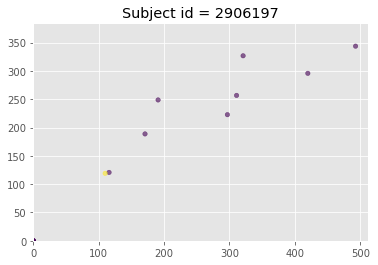

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


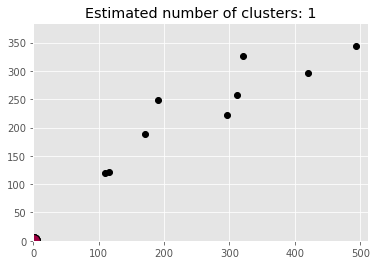

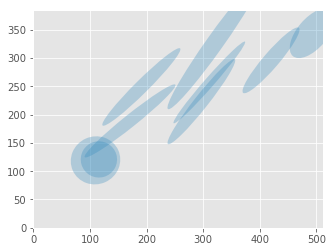

x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '2906197', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '2906197', 0, 0, 0, 0], [0, 0, '2906197', 0, 0, 0, 0], [0, 0, '2906197', 0, 0, 0, 0], [0, 0, '2906197', 0, 0, 0, 0], [0, 0, '2906197', 0, 0, 0, 0]]
key = coords2895959 value =  [[194.796875, 150.75, '2895959', 5, 105.39449701004318, 88.89460051094217, -33.38851357611151], [201.5, 145.46665954589844, '2895959', 5, 76.21679604916491, 68.60029154456998, -59.32271997820355], [0, 0, '2895959', 0, 0, 0, 0], [200.796875, 143.75, '2895959', 8, 66.60330322138685, 63.953107821277925, -63.03428556712986], [212.796875, 150.75, '2895959', 8, 64.8459713474939, 51.24451190127583, -197.02052561151987], [0, 0, '2895959', 0, 0, 0, 0]] 



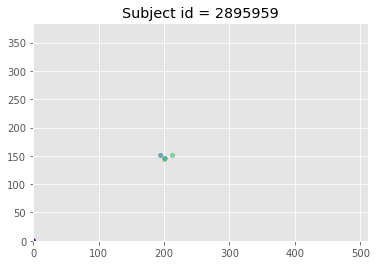

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


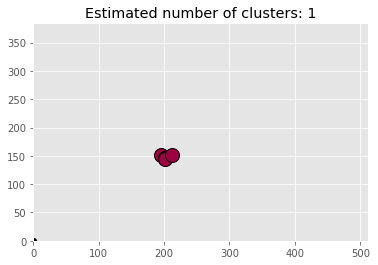

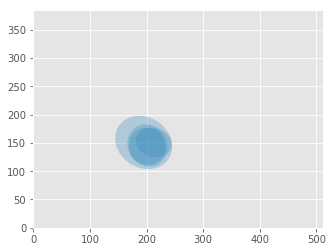

x_mean =  [202.47265625]
y_mean =  [147.67916488647461]
fringe_count_mean =  [6.5]
rx_mean =  [78.265141907022212]
ry_mean =  [68.173127944516466]
angle_mean =  [-67.24994181941031]
averages =  [[202.47265625], [147.67916488647461], [6.5], [78.265141907022212], [68.173127944516466], [-67.24994181941031]]
1

 average_list =  [[202.47265625, 147.67916488647461, '2895959', 6.5, 78.265141907022212, 68.173127944516466, -67.24994181941031]]

 keepgood =  [[194.796875, 150.75, '2895959', 5, 105.39449701004318, 88.89460051094217, -33.38851357611151], [201.5, 145.46665954589844, '2895959', 5, 76.21679604916491, 68.60029154456998, -59.32271997820355], [200.796875, 143.75, '2895959', 8, 66.60330322138685, 63.953107821277925, -63.03428556712986], [212.796875, 150.75, '2895959', 8, 64.8459713474939, 51.24451190127583, -197.02052561151987]]
key = coords2904157 value =  [[308.796875, 341.75, '2904157', 1, 43.840620433565945, 38.2099463490856, 42.87890360333856], [281.796875, 182.75, '2904157', 1, 54.

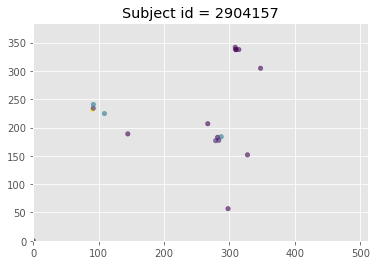

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


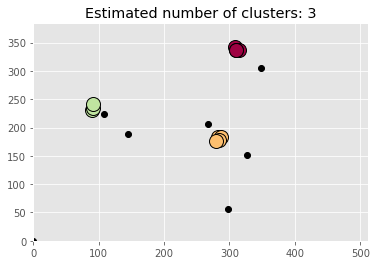

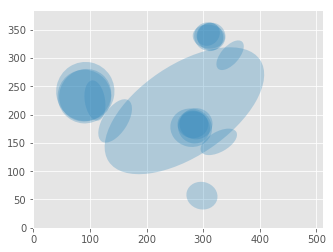

x_mean =  [310.63150787353516, 282.88150787353516, 91.243054707845047]
y_mean =  [338.66666412353516, 180.16666412353516, 235.52777608235678]
fringe_count_mean =  [1.0, 2.5, 6.0]
rx_mean =  [50.7866905556536, 61.267712864288484, 96.03933541782925]
ry_mean =  [44.779940325749344, 56.769375686013291, 97.873880274516623]
angle_mean =  [-1.6282849598508526, -15.208599029536051, -34.040569388648606]
averages =  [[310.63150787353516, 282.88150787353516, 91.243054707845047], [338.66666412353516, 180.16666412353516, 235.52777608235678], [1.0, 2.5, 6.0], [50.7866905556536, 61.267712864288484, 96.03933541782925], [44.779940325749344, 56.769375686013291, 97.873880274516623], [-1.6282849598508526, -15.208599029536051, -34.040569388648606]]
3

 average_list =  [[310.63150787353516, 338.66666412353516, '2904157', 1.0, 50.7866905556536, 44.779940325749344, -1.6282849598508526], [282.88150787353516, 180.16666412353516, '2904157', 2.5, 61.267712864288484, 56.769375686013291, -15.208599029536051], [91.2

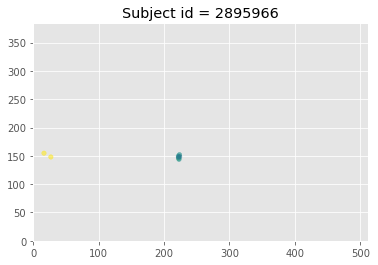

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


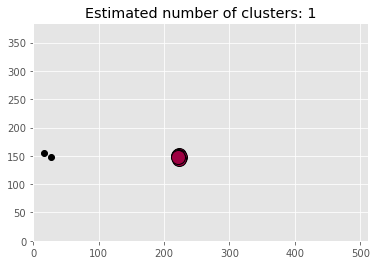

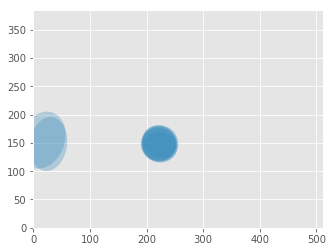

x_mean =  [222.69270833333334]
y_mean =  [147.88489532470703]
fringe_count_mean =  [6.0]
rx_mean =  [60.243701946111948]
ry_mean =  [61.689142081866954]
angle_mean =  [143.73797449254886]
averages =  [[222.69270833333334], [147.88489532470703], [6.0], [60.243701946111948], [61.689142081866954], [143.73797449254886]]
1

 average_list =  [[222.69270833333334, 147.88489532470703, '2895966', 6.0, 60.243701946111948, 61.689142081866954, 143.73797449254886]]

 keepgood =  [[223.5, 151.9499969482422, '2895966', 6, 55.47071299343465, 63.812224534175265, 57.804266065286754], [222.296875, 145.75, '2895966', 8, 65.7875368135941, 60.00833275470999, -203.57470620191265], [221.796875, 149.5, '2895966', 6, 62.48199740725323, 61.71709649683789, -49.60009566626328], [223.796875, 148.5, '2895966', 5, 64.8459713474939, 64.76109943476871, -76.6075022462489], [222.796875, 144, '2895966', 6, 52.3450093132096, 59.00847396772772, 89.02897806892085], [221.96875, 147.609375, '2895966', 5, 60.530983801686226, 60

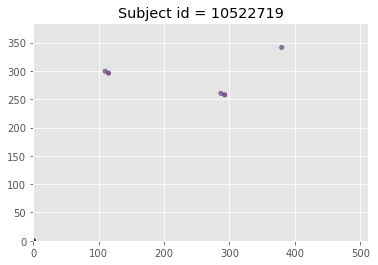

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


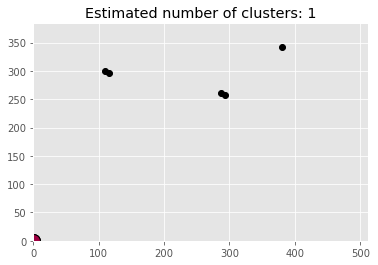

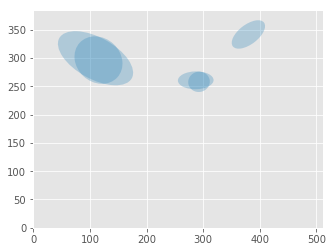

x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '10522719', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '10522719', 0, 0, 0, 0], [0, 0, '10522719', 0, 0, 0, 0], [0, 0, '10522719', 0, 0, 0, 0]]
key = coords2904167 value =  [[292, 201.4499969482422, '2904167', 7, 74.02702209328699, 77.64663547121665, -7.3995946598871], [74, 214.4499969482422, '2904167', 11, 106.30145812734649, 106.21205204683694, -8.664135433108058], [291.796875, 194.75, '2904167', 8, 64.8459713474939, 65.60487786742691, 52.43140797117252], [75.796875, 206.75, '2904167', 11, 92.09777413162601, 103.76897416858277, 27.5528115767178], [297.296875, 198.75, '2904167', 4, 80.39900496896712, 78.05767098754612, -2.202598161765806], [292.296875, 199.75, '2904167', 8, 70.21395872616783, 73.348483283569, -78.9964591482505], [73.296875, 219.75, '2904167', 11, 113.59577456930342, 106.1

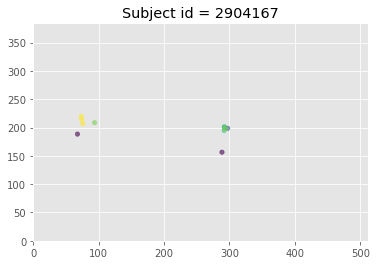

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


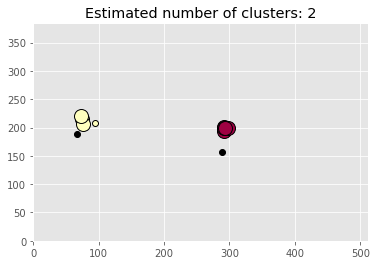

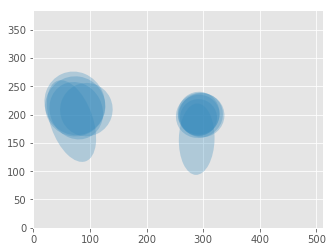

x_mean =  [293.34271240234375, 74.364583333333329]
y_mean =  [198.65592956542969, 213.64999898274741]
fringe_count_mean =  [7.2000000000000002, 11.0]
rx_mean =  [74.73435124858824, 103.9983356094253]
ry_mean =  [74.721593437615695, 105.36158301767601]
angle_mean =  [-23.368546944933474, -14.794324706044748]
averages =  [[293.34271240234375, 74.364583333333329], [198.65592956542969, 213.64999898274741], [7.2000000000000002, 11.0], [74.73435124858824, 103.9983356094253], [74.721593437615695, 105.36158301767601], [-23.368546944933474, -14.794324706044748]]
2

 average_list =  [[293.34271240234375, 198.65592956542969, '2904167', 7.2000000000000002, 74.73435124858824, 74.721593437615695, -23.368546944933474], [74.364583333333329, 213.64999898274741, '2904167', 11.0, 103.9983356094253, 105.36158301767601, -14.794324706044748]]

 keepgood =  [[292, 201.4499969482422, '2904167', 7, 74.02702209328699, 77.64663547121665, -7.3995946598871], [74, 214.4499969482422, '2904167', 11, 106.3014581273464

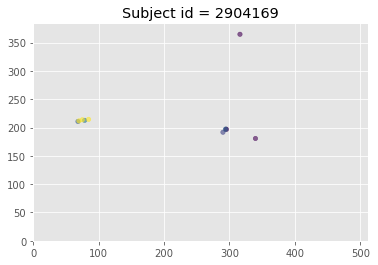

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


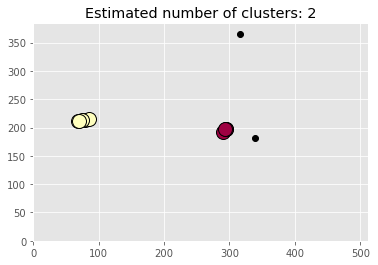

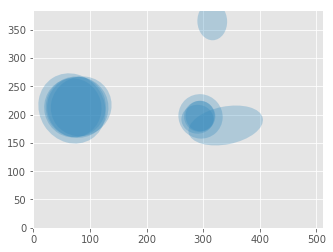

x_mean =  [293.3984375, 75.211680603027347]
y_mean =  [195.66666412353516, 212.67913208007812]
fringe_count_mean =  [3.0, 8.4000000000000004]
rx_mean =  [61.468155729856861, 110.30057391835672]
ry_mean =  [58.510748716750939, 107.93881000527601]
angle_mean =  [-2.632286943750179, -61.82909406397368]
averages =  [[293.3984375, 75.211680603027347], [195.66666412353516, 212.67913208007812], [3.0, 8.4000000000000004], [61.468155729856861, 110.30057391835672], [58.510748716750939, 107.93881000527601], [-2.632286943750179, -61.82909406397368]]
2

 average_list =  [[293.3984375, 195.66666412353516, '2904169', 3.0, 61.468155729856861, 58.510748716750939, -2.632286943750179], [75.211680603027347, 212.67913208007812, '2904169', 8.4000000000000004, 110.30057391835672, 107.93881000527601, -61.82909406397368]]

 keepgood =  [[290, 191.6999969482422, '2904169', 3, 57.0350769263968, 51.022054055084844, -1.6846843178962843], [78.5, 212.6999969482422, '2904169', 5, 107.73694816542745, 108.5034561661516

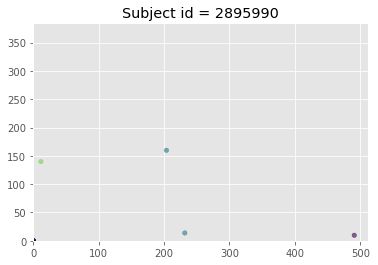

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


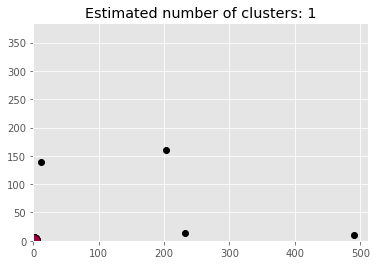

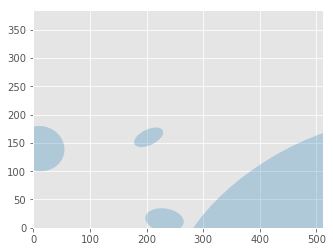

x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '2895990', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '2895990', 0, 0, 0, 0], [0, 0, '2895990', 0, 0, 0, 0], [0, 0, '2895990', 0, 0, 0, 0], [0, 0, '2895990', 0, 0, 0, 0], [0, 0, '2895990', 0, 0, 0, 0], [0, 0, '2895990', 0, 0, 0, 0]]
key = coords2906233 value =  [[117, 130.4666748046875, '2906233', 11, 77.12976821182103, 62.12889826803627, -266.3086140135487], [0, 0, '2906233', 0, 0, 0, 0], [110.24000549316406, 127.25999450683594, '2906233', 11, 60.27118964416625, 67.75998717288786, -43.110780096737166], [107, 117.46665954589844, '2906233', 7, 84.21995013059554, 77.93587107359485, -56.51383118448701], [116.296875, 115.75, '2906233', 11, 81.27115109311545, 71.21797525905943, -51.84277341263094], [285.296875, 107.75, '2906233', 1, 26.248809496813376, 25.553864678361276, -30.57922687248901], [

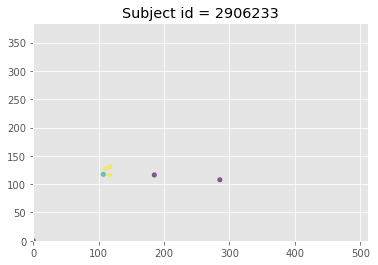

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


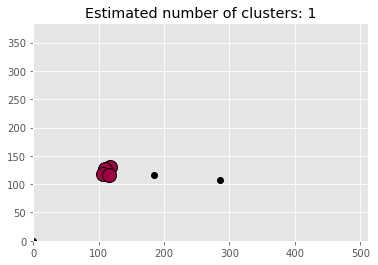

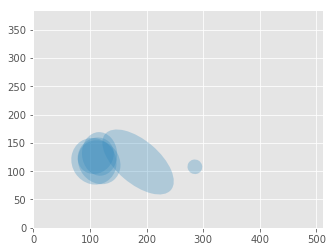

x_mean =  [112.63422012329102]
y_mean =  [122.73583221435547]
fringe_count_mean =  [10.0]
rx_mean =  [75.723014769924575]
ry_mean =  [69.760682943394599]
angle_mean =  [-35.43334853402362]
averages =  [[112.63422012329102], [122.73583221435547], [10.0], [75.723014769924575], [69.760682943394599], [-35.43334853402362]]
1

 average_list =  [[112.63422012329102, 122.73583221435547, '2906233', 10.0, 75.723014769924575, 69.760682943394599, -35.43334853402362]]

 keepgood =  [[117, 130.4666748046875, '2906233', 11, 77.12976821182103, 62.12889826803627, -266.3086140135487], [110.24000549316406, 127.25999450683594, '2906233', 11, 60.27118964416625, 67.75998717288786, -43.110780096737166], [107, 117.46665954589844, '2906233', 7, 84.21995013059554, 77.93587107359485, -56.51383118448701], [116.296875, 115.75, '2906233', 11, 81.27115109311545, 71.21797525905943, -51.84277341263094]]
key = coords2904193 value =  [[326.8125, 265.75, '2904193', 1, 409.8109320162165, 204.90546600810825, 150.3071427016

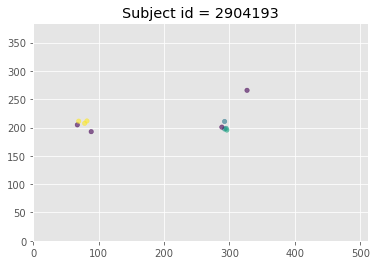

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


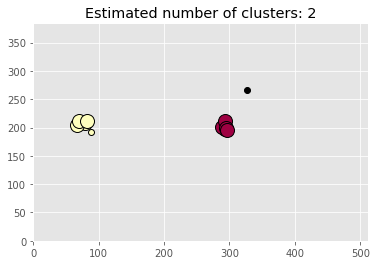

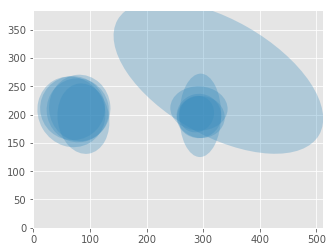

x_mean =  [292.81712646484374, 74.281406402587891]
y_mean =  [200.63520812988281, 208.78650283813477]
fringe_count_mean =  [5.0, 8.5]
rx_mean =  [89.619459270262467, 117.74567248958427]
ry_mean =  [78.844928599765211, 112.67796884112003]
angle_mean =  [-59.891233067695644, -77.08763983826877]
averages =  [[292.81712646484374, 74.281406402587891], [200.63520812988281, 208.78650283813477], [5.0, 8.5], [89.619459270262467, 117.74567248958427], [78.844928599765211, 112.67796884112003], [-59.891233067695644, -77.08763983826877]]
2

 average_list =  [[292.81712646484374, 200.63520812988281, '2904193', 5.0, 89.619459270262467, 78.844928599765211, -59.891233067695644], [74.281406402587891, 208.78650283813477, '2904193', 8.5, 117.74567248958427, 112.67796884112003, -77.08763983826877]]

 keepgood =  [[292.5, 197.46665954589844, '2904193', 6, 78.23683245840947, 79.30952023559341, -76.13897243697885], [78.5, 207.46665954589844, '2904193', 11, 113.26519040258498, 109.89540481748998, -76.2091349426

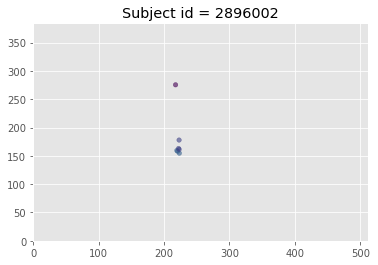

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


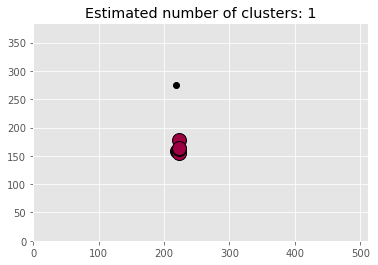

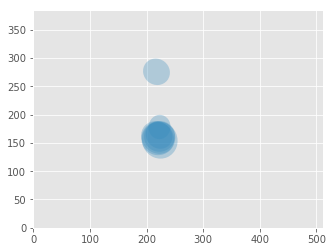

x_mean =  [221.9072291056315]
y_mean =  [162.47000885009766]
fringe_count_mean =  [3.5]
rx_mean =  [54.845546780026496]
ry_mean =  [53.32116271907546]
angle_mean =  [-117.59694747895726]
averages =  [[221.9072291056315], [162.47000885009766], [3.5], [54.845546780026496], [53.32116271907546], [-117.59694747895726]]
1

 average_list =  [[221.9072291056315, 162.47000885009766, '2896002', 3.5, 54.845546780026496, 53.32116271907546, -117.59694747895726]]

 keepgood =  [[219.5, 159.46665954589844, '2896002', 4, 61.40032573203501, 54.48853090330111, -42.76882539196875], [222.88644409179688, 177.94610595703125, '2896002', 3, 38.87335205078125, 43.082819153211396, -185.35582062321956], [220.6999969482422, 158.14999389648438, '2896002', 4, 59.54828819293815, 60.207956420706665, -48.36645644284278], [223.296875, 154.75, '2896002', 4, 65.79513659838392, 62.39390995922599, 114.22774531795419], [223, 161.4666748046875, '2896002', 3, 54.20332093147061, 55.154328932550705, -67.61986494804043], [222.06

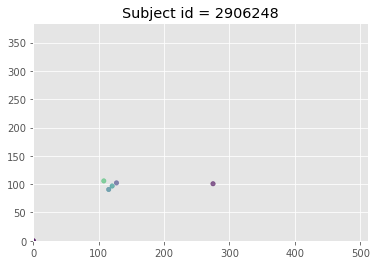

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


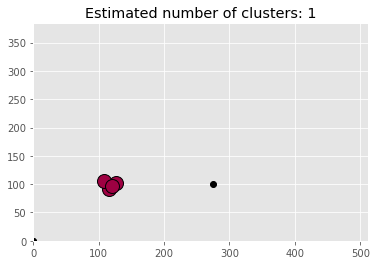

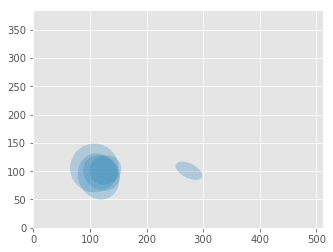

x_mean =  [117.69093894958496]
y_mean =  [98.837501525878906]
fringe_count_mean =  [5.5]
rx_mean =  [72.307833642170934]
ry_mean =  [68.180281290461863]
angle_mean =  [-38.604758619140235]
averages =  [[117.69093894958496], [98.837501525878906], [5.5], [72.307833642170934], [68.180281290461863], [-38.604758619140235]]
1

 average_list =  [[117.69093894958496, 98.837501525878906, '2906248', 5.5, 72.307833642170934, 68.180281290461863, -38.604758619140235]]

 keepgood =  [[115.25, 90.6300048828125, '2906248', 5, 83.45058418010026, 71.20847215390978, -65.89699102549517], [127.17000579833984, 102.22000122070312, '2906248', 3, 51.22499866550812, 57.29689253998725, -67.66936042162077], [107.796875, 105.75, '2906248', 8, 86.14522621712709, 85.61541917201598, 75.80144597613685], [120.546875, 96.75, '2906248', 6, 68.41052550594829, 58.60034129593445, -36.67434966957316]]
key = coords2904201 value =  [[298.2572326660156, 196.89413452148438, '2904201', 8, 84.31156394957192, 82.3053041655455, -136

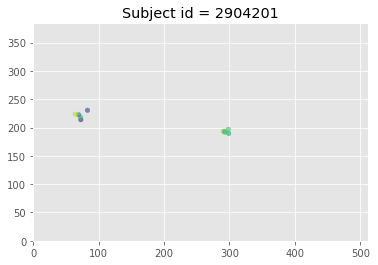

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


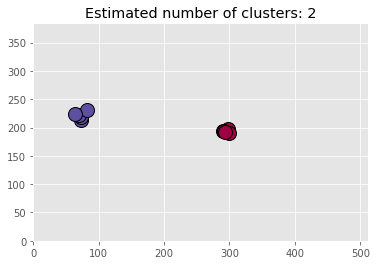

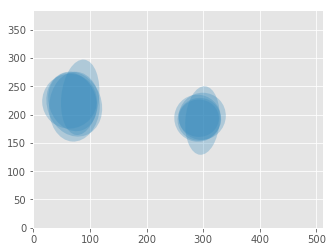

x_mean =  [294.5233215332031, 72.197315979003903]
y_mean =  [193.00070190429688, 221.80644836425782]
fringe_count_mean =  [8.1999999999999993, 5.5999999999999996]
rx_mean =  [87.423484952258335, 110.98096492437546]
ry_mean =  [73.306575380630562, 90.903087511560429]
angle_mean =  [-92.07229865409411, -82.41104547573187]
averages =  [[294.5233215332031, 72.197315979003903], [193.00070190429688, 221.80644836425782], [8.1999999999999993, 5.5999999999999996], [87.423484952258335, 110.98096492437546], [73.306575380630562, 90.903087511560429], [-92.07229865409411, -82.41104547573187]]
2

 average_list =  [[294.5233215332031, 193.00070190429688, '2904201', 8.1999999999999993, 87.423484952258335, 73.306575380630562, -92.07229865409411], [72.197315979003903, 221.80644836425782, '2904201', 5.5999999999999996, 110.98096492437546, 90.903087511560429, -82.41104547573187]]

 keepgood =  [[298.2572326660156, 196.89413452148438, '2904201', 8, 84.31156394957192, 82.3053041655455, -136.36392299384264], 

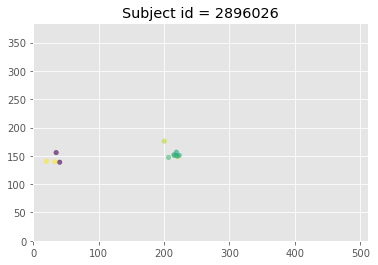

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


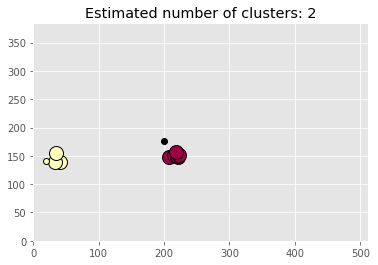

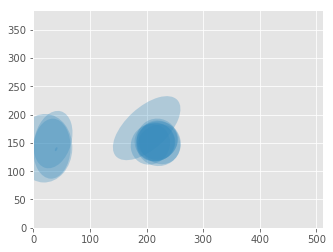

x_mean =  [217.09058925083704, 36.003960927327476]
y_mean =  [150.88807242257255, 144.78941853841147]
fringe_count_mean =  [7.5714285714285712, 4.333333333333333]
rx_mean =  [73.46781003949593, 72.430268822338817]
ry_mean =  [70.272691765245696, 45.016462522072743]
angle_mean =  [-29.74541508661198, -103.81124924704926]
averages =  [[217.09058925083704, 36.003960927327476], [150.88807242257255, 144.78941853841147], [7.5714285714285712, 4.333333333333333], [73.46781003949593, 72.430268822338817], [70.272691765245696, 45.016462522072743], [-29.74541508661198, -103.81124924704926]]
2

 average_list =  [[217.09058925083704, 150.88807242257255, '2896026', 7.5714285714285712, 73.46781003949593, 70.272691765245696, -29.74541508661198], [36.003960927327476, 144.78941853841147, '2896026', 4.333333333333333, 72.430268822338817, 45.016462522072743, -103.81124924704926]]

 keepgood =  [[215.89999389648438, 151.1999969482422, '2896026', 6, 67.89698078707183, 67.20119046564577, 36.52885536698517], [

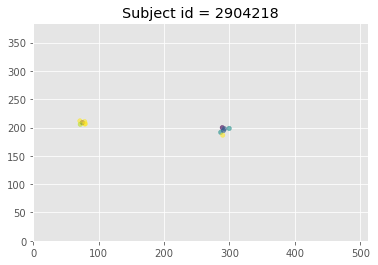

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


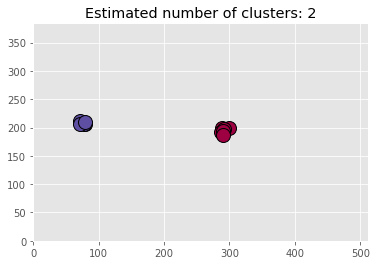

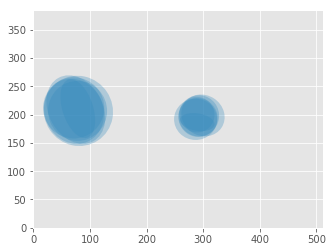

x_mean =  [291.30831400553387, 75.70629755655925]
y_mean =  [194.82448069254556, 208.26948801676431]
fringe_count_mean =  [5.333333333333333, 9.1666666666666661]
rx_mean =  [70.343864619409814, 115.08339295684482]
ry_mean =  [62.749183921195218, 98.046150286136765]
angle_mean =  [-3.5666825611951776, -1.5540199678555595]
averages =  [[291.30831400553387, 75.70629755655925], [194.82448069254556, 208.26948801676431], [5.333333333333333, 9.1666666666666661], [70.343864619409814, 115.08339295684482], [62.749183921195218, 98.046150286136765], [-3.5666825611951776, -1.5540199678555595]]
2

 average_list =  [[291.30831400553387, 194.82448069254556, '2904218', 5.333333333333333, 70.343864619409814, 62.749183921195218, -3.5666825611951776], [75.70629755655925, 208.26948801676431, '2904218', 9.1666666666666661, 115.08339295684482, 98.046150286136765, -1.5540199678555595]]

 keepgood =  [[299.5, 198.46665954589844, '2904218', 6, 78.77182237323191, 71.56117544489415, -213.0238608976638], [79.5, 20

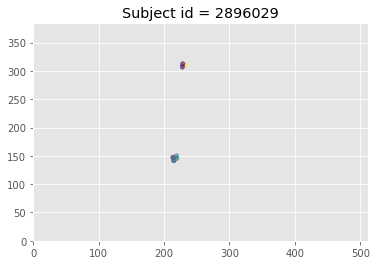

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


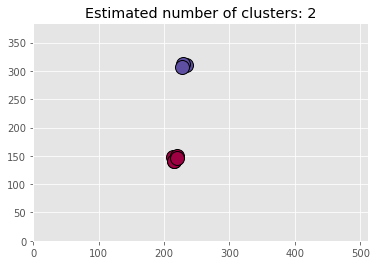

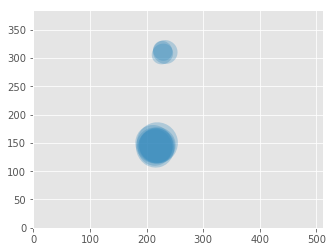

x_mean =  [216.6015625, 229.83333333333334]
y_mean =  [145.30607350667319, 309.96112060546875]
fringe_count_mean =  [5.0, 4.333333333333333]
rx_mean =  [67.008313782067248, 38.367905039087731]
ry_mean =  [65.678102489155734, 38.059697107235955]
angle_mean =  [-48.201599646082414, -43.80649709190963]
averages =  [[216.6015625, 229.83333333333334], [145.30607350667319, 309.96112060546875], [5.0, 4.333333333333333], [67.008313782067248, 38.367905039087731], [65.678102489155734, 38.059697107235955], [-48.201599646082414, -43.80649709190963]]
2

 average_list =  [[216.6015625, 145.30607350667319, '2896029', 5.0, 67.008313782067248, 65.678102489155734, -48.201599646082414], [229.83333333333334, 309.96112060546875, '2896029', 4.333333333333333, 38.367905039087731, 38.059697107235955, -43.80649709190963]]

 keepgood =  [[215, 141.703125, '2896029', 3, 67.05221845696084, 71.16881339463234, 17.35402463626132], [218, 145.4499969482422, '2896029', 11, 64.28841264178172, 59.90826320300064, -15.3332

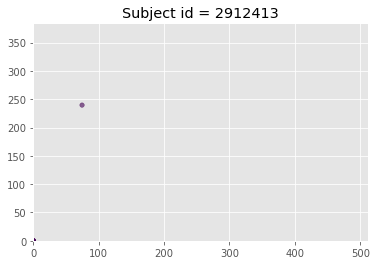

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


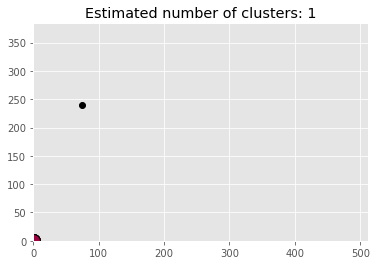

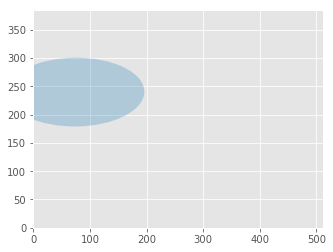

x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '2912413', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '2912413', 0, 0, 0, 0], [0, 0, '2912413', 0, 0, 0, 0], [0, 0, '2912413', 0, 0, 0, 0], [0, 0, '2912413', 0, 0, 0, 0], [0, 0, '2912413', 0, 0, 0, 0], [0, 0, '2912413', 0, 0, 0, 0]]
key = coords2896034 value =  [[0, 0, '2896034', 0, 0, 0, 0], [0, 0, '2896034', 0, 0, 0, 0], [213.796875, 134.5, '2896034', 3, 83.16850365372699, 41.58425182686349, -18.217095197824847], [0, 0, '2896034', 0, 0, 0, 0], [0, 0, '2896034', 0, 0, 0, 0], [0, 0, '2896034', 0, 0, 0, 0]] 



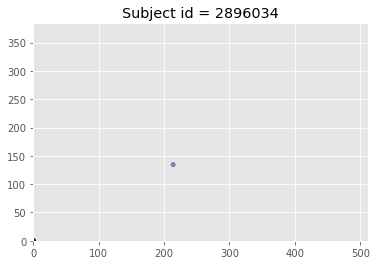

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


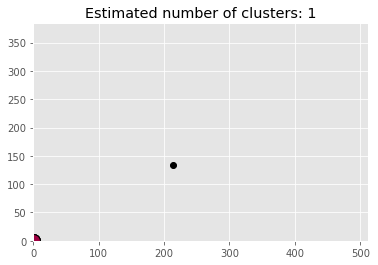

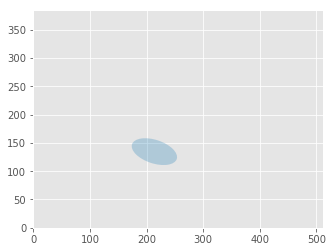

x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '2896034', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '2896034', 0, 0, 0, 0], [0, 0, '2896034', 0, 0, 0, 0], [0, 0, '2896034', 0, 0, 0, 0], [0, 0, '2896034', 0, 0, 0, 0], [0, 0, '2896034', 0, 0, 0, 0]]
key = coords2906276 value =  [[95.296875, 109.75, '2906276', 6, 91.2414379544733, 80.62257748298549, -66.61477894278624], [102.296875, 131.75, '2906276', 1, 78.26237921249263, 60.207972893961475, -32.10625595511784], [334.296875, 138.75, '2906276', 1, 49.16299421312742, 34.132096331752024, 5.042451069170923], [98.796875, 110.75, '2906276', 11, 94.02127418834527, 102.53292154230269, -44.60486295749251], [101.296875, 109.75, '2906276', 11, 85.38149682454625, 95.90099061010788, -78.57289840605486], [0, 0, '2906276', 0, 0, 0, 0], [75.73819732666016, 95.78118133544922, '2906276', 9, 109.163892929

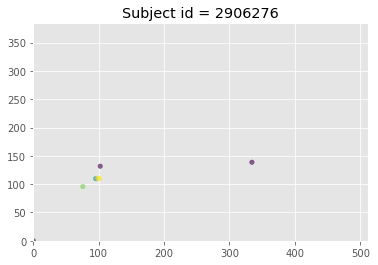

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


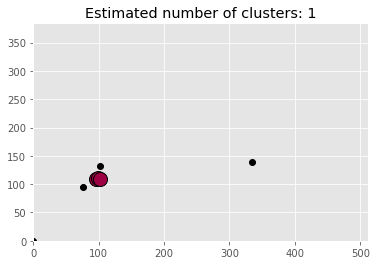

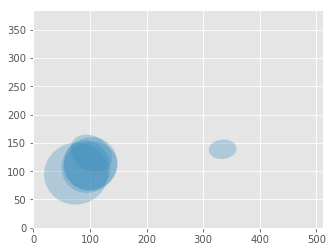

x_mean =  [98.463541666666671]
y_mean =  [110.08333333333333]
fringe_count_mean =  [9.3333333333333339]
rx_mean =  [90.214736322454939]
ry_mean =  [93.018829878465354]
angle_mean =  [-63.313893864339924]
averages =  [[98.463541666666671], [110.08333333333333], [9.3333333333333339], [90.214736322454939], [93.018829878465354], [-63.313893864339924]]
1

 average_list =  [[98.463541666666671, 110.08333333333333, '2906276', 9.3333333333333339, 90.214736322454939, 93.018829878465354, -63.313893864339924]]

 keepgood =  [[95.296875, 109.75, '2906276', 6, 91.2414379544733, 80.62257748298549, -66.61477894278624], [98.796875, 110.75, '2906276', 11, 94.02127418834527, 102.53292154230269, -44.60486295749251], [101.296875, 109.75, '2906276', 11, 85.38149682454625, 95.90099061010788, -78.57289840605486]]
key = coords2896039 value =  [[215.39999389648438, 153.10000610351562, '2896039', 6, 75.66372975210778, 65.21502894272147, -234.36019080191335], [212.5, 156.46665954589844, '2896039', 8, 86.55634003

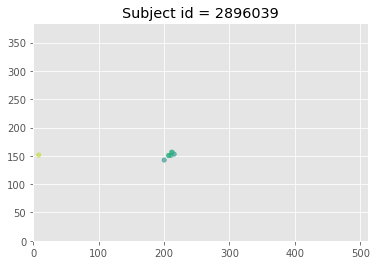

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


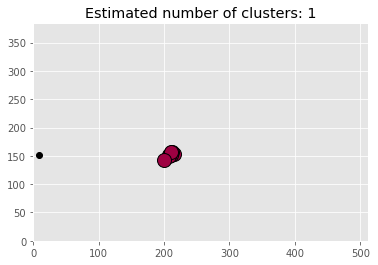

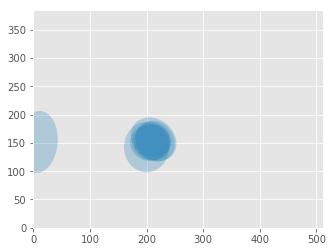

x_mean =  [209.11803981236048]
y_mean =  [151.52209254673548]
fringe_count_mean =  [7.0]
rx_mean =  [72.714926760737583]
ry_mean =  [67.600564600331225]
angle_mean =  [-146.56816431531144]
averages =  [[209.11803981236048], [151.52209254673548], [7.0], [72.714926760737583], [67.600564600331225], [-146.56816431531144]]
1

 average_list =  [[209.11803981236048, 151.52209254673548, '2896039', 7.0, 72.714926760737583, 67.600564600331225, -146.56816431531144]]

 keepgood =  [[215.39999389648438, 153.10000610351562, '2896039', 6, 75.66372975210778, 65.21502894272147, -234.36019080191335], [212.5, 156.46665954589844, '2896039', 8, 86.55634003352961, 70.43436661176133, -218.6598082540901], [210.40232849121094, 150.70465087890625, '2896039', 7, 62.07971491088951, 64.26966381089034, -120.31067338795278], [206.796875, 150.75, '2896039', 8, 72.06247289678588, 66.12110101926616, -183.46822925891718], [207.296875, 150.5, '2896039', 7, 64.8459713474939, 61.97176776565277, -26.56505117707799], [211.29

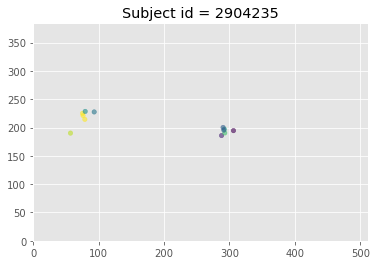

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


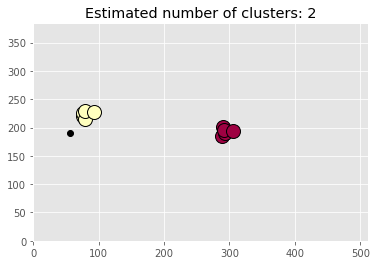

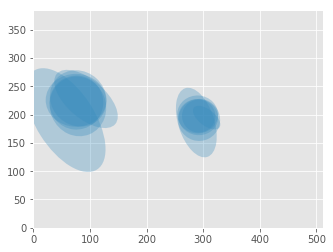

x_mean =  [293.37713877360028, 80.501174926757812]
y_mean =  [193.96797307332358, 223.39628906249999]
fringe_count_mean =  [4.333333333333333, 8.8000000000000007]
rx_mean =  [76.67752079307941, 109.77767765818116]
ry_mean =  [59.216217904712714, 90.212201206883961]
angle_mean =  [-31.101918630256026, -31.67326185053307]
averages =  [[293.37713877360028, 80.501174926757812], [193.96797307332358, 223.39628906249999], [4.333333333333333, 8.8000000000000007], [76.67752079307941, 109.77767765818116], [59.216217904712714, 90.212201206883961], [-31.101918630256026, -31.67326185053307]]
2

 average_list =  [[293.37713877360028, 193.96797307332358, '2904235', 4.333333333333333, 76.67752079307941, 59.216217904712714, -31.101918630256026], [80.501174926757812, 223.39628906249999, '2904235', 8.8000000000000007, 109.77767765818116, 90.212201206883961, -31.67326185053307]]

 keepgood =  [[287.8359069824219, 185.88055419921875, '2904235', 2, 127.38434740562057, 63.69217370281029, -72.1810994176877], 

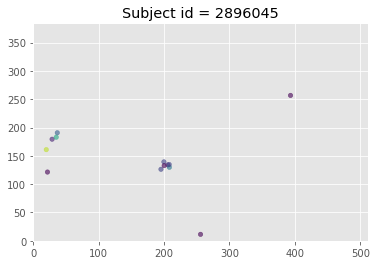

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


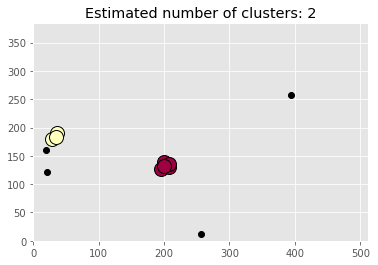

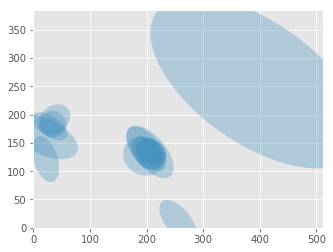

x_mean =  [202.76850636800131, 33.460166931152344]
y_mean =  [132.83533350626627, 184.35450744628906]
fringe_count_mean =  [2.8333333333333335, 4.333333333333333]
rx_mean =  [76.893075515507945, 60.596827119302823]
ry_mean =  [51.462101196761374, 43.336651888504242]
angle_mean =  [-132.3679831432588, -77.38162135806303]
averages =  [[202.76850636800131, 33.460166931152344], [132.83533350626627, 184.35450744628906], [2.8333333333333335, 4.333333333333333], [76.893075515507945, 60.596827119302823], [51.462101196761374, 43.336651888504242], [-132.3679831432588, -77.38162135806303]]
2

 average_list =  [[202.76850636800131, 132.83533350626627, '2896045', 2.8333333333333335, 76.893075515507945, 51.462101196761374, -132.3679831432588], [33.460166931152344, 184.35450744628906, '2896045', 4.333333333333333, 60.596827119302823, 43.336651888504242, -77.38162135806303]]

 keepgood =  [[205.796875, 134, '2896045', 2, 112.0446339634344, 56.0223169817172, -49.34323995168939], [28.700000762939453, 17

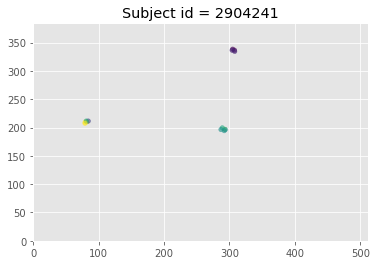

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


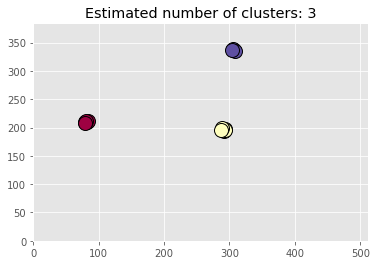

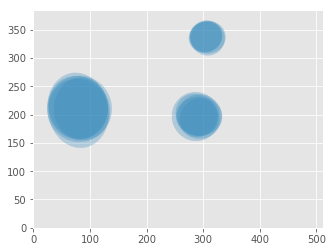

x_mean =  [80.972166442871099, 290.84992675781251, 306.11837768554688]
y_mean =  [210.02070922851561, 196.77179565429688, 336.52450561523438]
fringe_count_mean =  [8.4000000000000004, 6.7999999999999998, 1.25]
rx_mean =  [116.9818165563014, 74.053049156326153, 58.293227876173546]
ry_mean =  [105.50995420472596, 79.036917868539732, 59.014339193363433]
angle_mean =  [-67.1303746340024, -104.43873010712879, -67.54069477324404]
averages =  [[80.972166442871099, 290.84992675781251, 306.11837768554688], [210.02070922851561, 196.77179565429688, 336.52450561523438], [8.4000000000000004, 6.7999999999999998, 1.25], [116.9818165563014, 74.053049156326153, 58.293227876173546], [105.50995420472596, 79.036917868539732, 59.014339193363433], [-67.1303746340024, -104.43873010712879, -67.54069477324404]]
3

 average_list =  [[80.972166442871099, 210.02070922851561, '2904241', 8.4000000000000004, 116.9818165563014, 105.50995420472596, -67.1303746340024], [290.84992675781251, 196.77179565429688, '2904241'

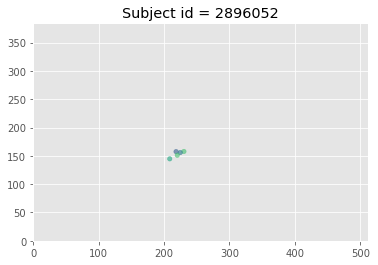

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


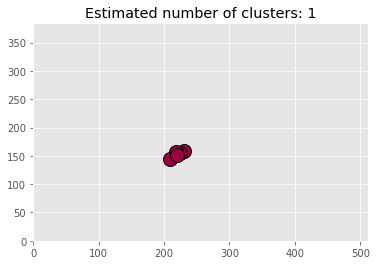

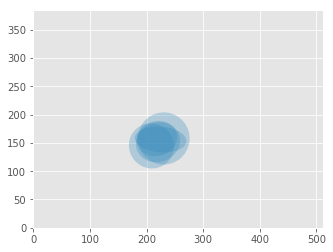

x_mean =  [220.40694274902344]
y_mean =  [153.39973449707031]
fringe_count_mean =  [6.4000000000000004]
rx_mean =  [81.160300423389032]
ry_mean =  [71.278283497335607]
angle_mean =  [-17.845122228657306]
averages =  [[220.40694274902344], [153.39973449707031], [6.4000000000000004], [81.160300423389032], [71.278283497335607], [-17.845122228657306]]
1

 average_list =  [[220.40694274902344, 153.39973449707031, '2896052', 6.4000000000000004, 81.160300423389032, 71.278283497335607, -17.845122228657306]]

 keepgood =  [[230.296875, 157.75, '2896052', 8, 92.13576938409967, 91.44397191723465, 84.35175262626476], [224.6999969482422, 155.86666870117188, '2896052', 5, 91.26883367283708, 45.63441683641854, 175.6012946450045], [218.296875, 157.5, '2896052', 4, 72.42237223399962, 61.40032573203501, 16.073574164746404], [208.60787963867188, 144.7286834716797, '2896052', 7, 80.62257748298549, 78.74642849044012, -49.63546342690264], [220.13308715820312, 151.1533203125, '2896052', 8, 69.35194934302329,

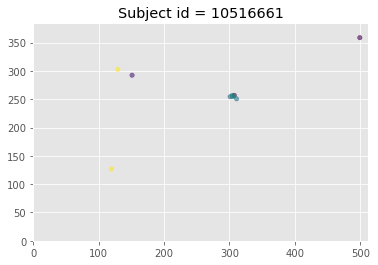

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


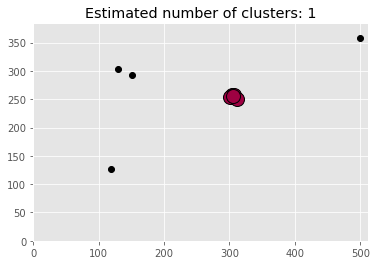

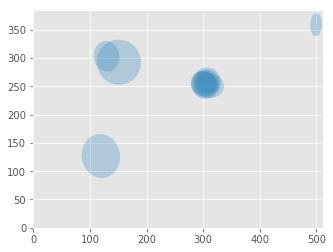

x_mean =  [305.53125]
y_mean =  [254.81944783528647]
fringe_count_mean =  [4.666666666666667]
rx_mean =  [45.022097879599272]
ry_mean =  [46.707795300747385]
angle_mean =  [-40.28683042473539]
averages =  [[305.53125], [254.81944783528647], [4.666666666666667], [45.022097879599272], [46.707795300747385], [-40.28683042473539]]
1

 average_list =  [[305.53125, 254.81944783528647, '10516661', 4.666666666666667, 45.022097879599272, 46.707795300747385, -40.28683042473539]]

 keepgood =  [[304.296875, 256.75, '10516661', 6, 38.63935817272331, 43.965895873961216, 17.198541220065877], [304.796875, 254.75, '10516661', 5, 47.4236228055175, 49.76946855251722, -22.44275336529435], [301, 254.4666748046875, '10516661', 4, 47.16990566028302, 43.382037644465015, -32.005383208083494], [307.296875, 256.75, '10516661', 1, 33.421549934136806, 43.86342439892262, -128.9275435927923], [310.796875, 250.75, '10516661', 5, 52, 43.18564576337837, -185.31454566994475], [305, 255.45001220703125, '10516661', 7, 51.

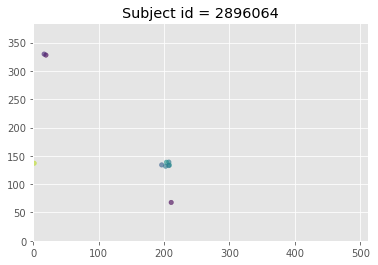

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


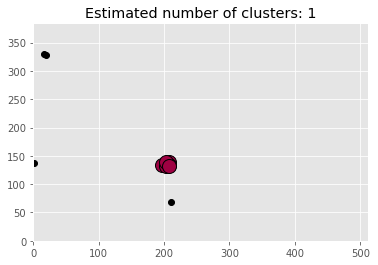

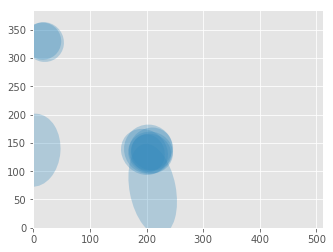

x_mean =  [204.08866882324219]
y_mean =  [134.98099009195963]
fringe_count_mean =  [5.166666666666667]
rx_mean =  [77.502915765674047]
ry_mean =  [73.476135755954033]
angle_mean =  [-107.78694252468149]
averages =  [[204.08866882324219], [134.98099009195963], [5.166666666666667], [77.502915765674047], [73.476135755954033], [-107.78694252468149]]
1

 average_list =  [[204.08866882324219, 134.98099009195963, '2896064', 5.166666666666667, 77.502915765674047, 73.476135755954033, -107.78694252468149]]

 keepgood =  [[207.296875, 139, '2896064', 5, 73.66138744281159, 79.51100552753688, -230.1021652523582], [196.296875, 134, '2896064', 4, 86.83317338436964, 77.33692520394123, -40.279863068956445], [202.296875, 131.75, '2896064', 5, 66.73080248281148, 59.20304046246274, -74.32047587758075], [208.14138793945312, 133.6259307861328, '2896064', 6, 71.96099380798309, 63.682445842709534, -24.41348501580294], [203.5, 138.75, '2896064', 6, 86.45229898620394, 87.36704184073076, -146.6737103128848], [20

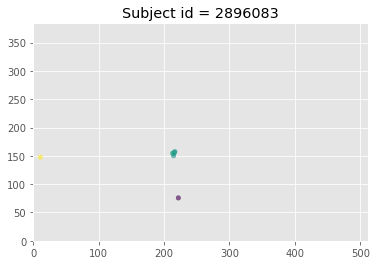

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


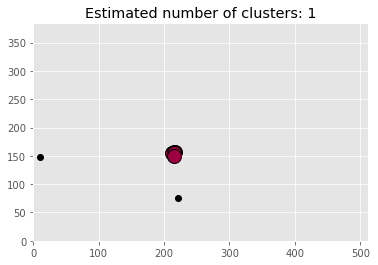

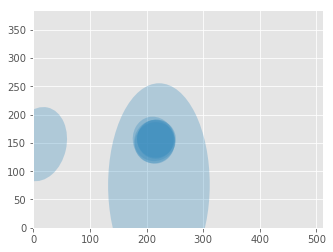

x_mean =  [214.84812316894531]
y_mean =  [154.55728759765626]
fringe_count_mean =  [6.4000000000000004]
rx_mean =  [72.021877104526453]
ry_mean =  [71.089695677891456]
angle_mean =  [-54.738211500088596]
averages =  [[214.84812316894531], [154.55728759765626], [6.4000000000000004], [72.021877104526453], [71.089695677891456], [-54.738211500088596]]
1

 average_list =  [[214.84812316894531, 154.55728759765626, '2896083', 6.4000000000000004, 72.021877104526453, 71.089695677891456, -54.738211500088596]]

 keepgood =  [[216.5, 157.46665954589844, '2896083', 6, 66.64082832618455, 67.60177512462228, -25.79602649449995], [212.796875, 154.75, '2896083', 7, 83.5224520712844, 73.97972695272672, -76.71513351509782], [215.5, 155.96665954589844, '2896083', 6, 68.26419266350405, 64.4980619863884, -84.95754893082909], [214.97499084472656, 154.39999389648438, '2896083', 7, 71.58911682615907, 75.16648848936326, -49.316039511984314], [214.46875, 150.203125, '2896083', 6, 70.09279563550022, 74.20242583635

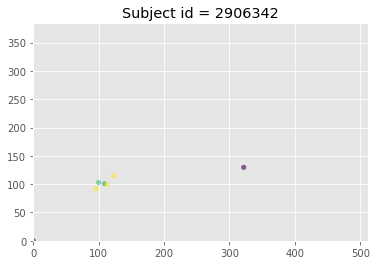

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


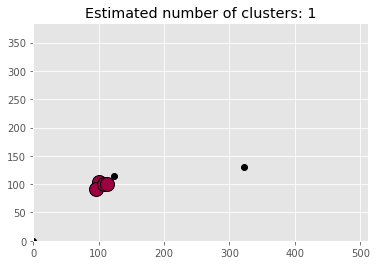

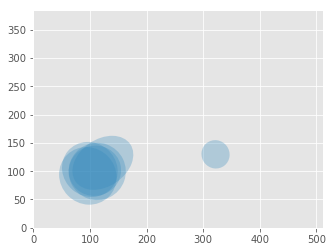

x_mean =  [104.421875]
y_mean =  [98.75]
fringe_count_mean =  [9.25]
rx_mean =  [99.827971455538176]
ry_mean =  [95.77397391447542]
angle_mean =  [-69.72888999800276]
averages =  [[104.421875], [98.75], [9.25], [99.827971455538176], [95.77397391447542], [-69.72888999800276]]
1

 average_list =  [[104.421875, 98.75, '2906342', 9.25, 99.827971455538176, 95.77397391447542, -69.72888999800276]]

 keepgood =  [[99.796875, 103, '2906342', 8, 101.17806086301516, 94.36630754670864, -40.2720121811578], [96.296875, 91.75, '2906342', 11, 104.35037134576953, 99.00505037623081, -45.81845546168861], [108.796875, 100.75, '2906342', 7, 92.64987857520376, 88.64536084872124, -166.26373169437744], [112.796875, 99.5, '2906342', 11, 101.13357503816425, 101.07917688624102, -64.19546760005288]]
key = coords2896107 value =  [[58.583396911621094, 333.4312438964844, '2896107', 10, 115.1131591796875, 57.55657958984375, 90], [214.71389770507812, 174.6544647216797, '2896107', 10, 108.37638624637697, 54.18819312318

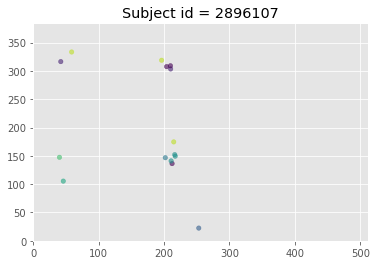

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


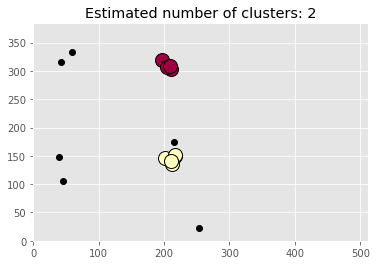

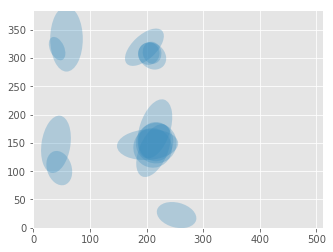

x_mean =  [204.93979644775391, 211.58171386718749]
y_mean =  [309.76277923583984, 145.17644348144532]
fringe_count_mean =  [3.5, 4.7999999999999998]
rx_mean =  [53.840761163325581, 83.853668032146246]
ry_mean =  [39.81658331908055, 61.081485952067318]
angle_mean =  [-39.87609194317005, -53.54760355149954]
averages =  [[204.93979644775391, 211.58171386718749], [309.76277923583984, 145.17644348144532], [3.5, 4.7999999999999998], [53.840761163325581, 83.853668032146246], [39.81658331908055, 61.081485952067318], [-39.87609194317005, -53.54760355149954]]
2

 average_list =  [[204.93979644775391, 309.76277923583984, '2896107', 3.5, 53.840761163325581, 39.81658331908055, -39.87609194317005], [211.58171386718749, 145.17644348144532, '2896107', 4.7999999999999998, 83.853668032146246, 61.081485952067318, -53.54760355149954]]

 keepgood =  [[196.18994140625, 318.876708984375, '2896107', 10, 85.18594092704649, 42.592970463523244, 43.111810717988035], [201.796875, 146.75, '2896107', 5, 108.16653826

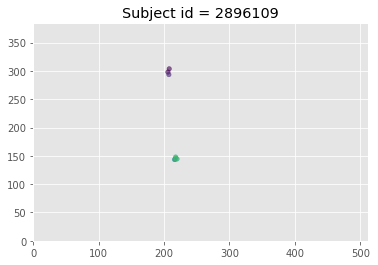

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


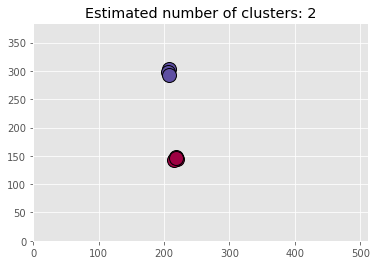

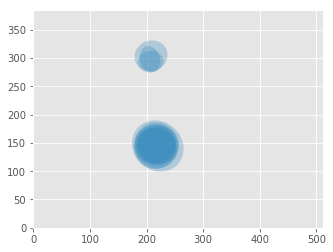

x_mean =  [217.69946725027901, 206.97896830240884]
y_mean =  [145.24463108607702, 298.41502888997394]
fringe_count_mean =  [7.2857142857142856, 1.3333333333333333]
rx_mean =  [75.31858373430093, 48.083762372245047]
ry_mean =  [73.597130370852568, 44.324363475884162]
angle_mean =  [-14.0187832185929, -49.531949456446206]
averages =  [[217.69946725027901, 206.97896830240884], [145.24463108607702, 298.41502888997394], [7.2857142857142856, 1.3333333333333333], [75.31858373430093, 48.083762372245047], [73.597130370852568, 44.324363475884162], [-14.0187832185929, -49.531949456446206]]
2

 average_list =  [[217.69946725027901, 145.24463108607702, '2896109', 7.2857142857142856, 75.31858373430093, 73.597130370852568, -14.0187832185929], [206.97896830240884, 298.41502888997394, '2896109', 1.3333333333333333, 48.083762372245047, 44.324363475884162, -49.531949456446206]]

 keepgood =  [[217.796875, 145.75, '2896109', 6, 78.26237921249263, 81.74350127074322, 14.886266849017574], [207.796875, 303.75

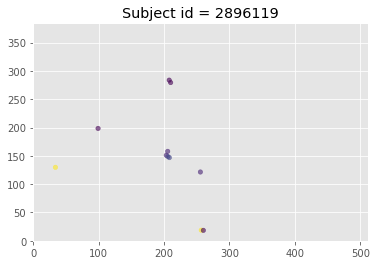

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


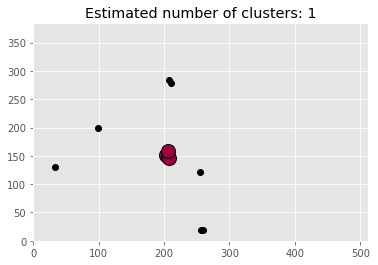

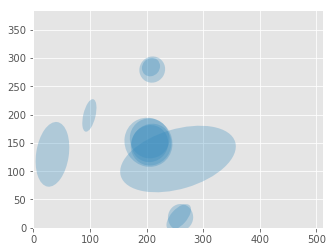

x_mean =  [205.6484375]
y_mean =  [151.16166305541992]
fringe_count_mean =  [2.5]
rx_mean =  [73.961576675796167]
ry_mean =  [73.055044045258072]
angle_mean =  [-67.12753414024627]
averages =  [[205.6484375], [151.16166305541992], [2.5], [73.961576675796167], [73.055044045258072], [-67.12753414024627]]
1

 average_list =  [[205.6484375, 151.16166305541992, '2896119', 2.5, 73.961576675796167, 73.055044045258072, -67.12753414024627]]

 keepgood =  [[203.296875, 151, '2896119', 2, 88.40814442120137, 83.07376240426336, -55.544758875006764], [205.796875, 148.75, '2896119', 3, 66.40030120413611, 63.89053137985315, -129.92039213998544], [208, 146.92999267578125, '2896119', 3, 70.2353187506115, 75.2844596587722, -33.90959232524797], [205.5, 157.96665954589844, '2896119', 2, 70.80254232723568, 69.9714227381436, -59.03624346792648]]
key = coords2906361 value =  [[123.5, 109.46666717529297, '2906361', 11, 85.44589556037957, 80.77747210701756, -58.67130713219583], [113, 84.46665954589844, '2906361

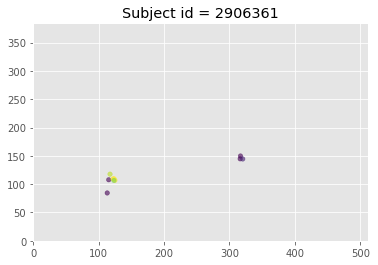

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


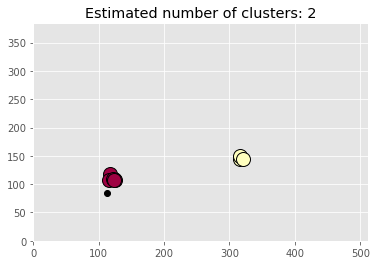

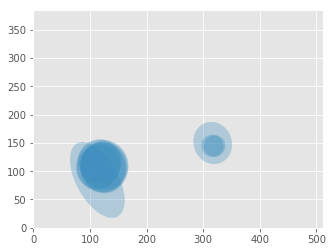

x_mean =  [121.01125081380208, 317.796875]
y_mean =  [109.57944615681966, 146.33333333333334]
fringe_count_mean =  [8.8333333333333339, 1.3333333333333333]
rx_mean =  [84.971746118792964, 50.858827440223649]
ry_mean =  [82.494329144588576, 48.174620729790583]
angle_mean =  [-49.956405951921376, 108.0217220522497]
averages =  [[121.01125081380208, 317.796875], [109.57944615681966, 146.33333333333334], [8.8333333333333339, 1.3333333333333333], [84.971746118792964, 50.858827440223649], [82.494329144588576, 48.174620729790583], [-49.956405951921376, 108.0217220522497]]
2

 average_list =  [[121.01125081380208, 109.57944615681966, '2906361', 8.8333333333333339, 84.971746118792964, 82.494329144588576, -49.956405951921376], [317.796875, 146.33333333333334, '2906361', 1.3333333333333333, 50.858827440223649, 48.174620729790583, 108.0217220522497]]

 keepgood =  [[123.5, 109.46666717529297, '2906361', 11, 85.44589556037957, 80.77747210701756, -58.67130713219583], [117.296875, 117.75, '2906361', 

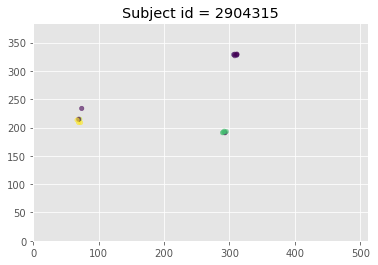

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


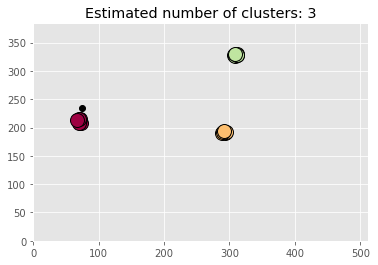

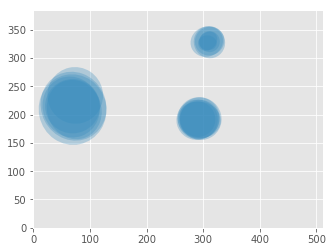

x_mean =  [69.754791259765625, 292.12899271647137, 309.295659383138]
y_mean =  [212.06866760253905, 191.89222462972006, 328.55888875325519]
fringe_count_mean =  [8.8000000000000007, 6.833333333333333, 1.3333333333333333]
rx_mean =  [112.01840640319851, 71.627449680761558, 44.410374899671019]
ry_mean =  [105.12119196347449, 69.658351982590787, 42.954716747178345]
angle_mean =  [-41.37375880583218, -62.10731210870292, 16.15436664990165]
averages =  [[69.754791259765625, 292.12899271647137, 309.295659383138], [212.06866760253905, 191.89222462972006, 328.55888875325519], [8.8000000000000007, 6.833333333333333, 1.3333333333333333], [112.01840640319851, 71.627449680761558, 44.410374899671019], [105.12119196347449, 69.658351982590787, 42.954716747178345], [-41.37375880583218, -62.10731210870292, 16.15436664990165]]
3

 average_list =  [[69.754791259765625, 212.06866760253905, '2904315', 8.8000000000000007, 112.01840640319851, 105.12119196347449, -41.37375880583218], [292.12899271647137, 191.8

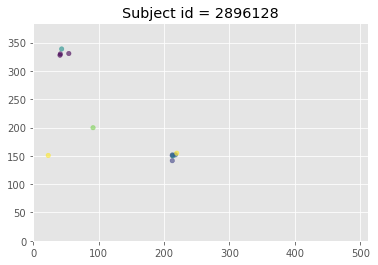

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


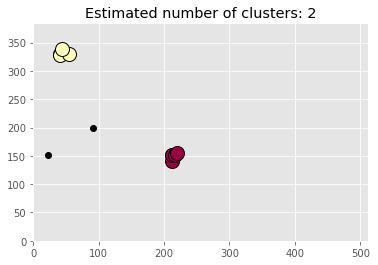

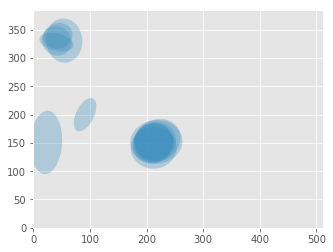

x_mean =  [214.65138498942056, 44.927082061767578]
y_mean =  [150.05555216471353, 331.81119537353516]
fringe_count_mean =  [5.166666666666667, 2.0]
rx_mean =  [75.557719806479525, 61.635773084816115]
ry_mean =  [75.418645979128868, 47.659268167119514]
angle_mean =  [-90.17694155584968, -16.042085412815123]
averages =  [[214.65138498942056, 44.927082061767578], [150.05555216471353, 331.81119537353516], [5.166666666666667, 2.0], [75.557719806479525, 61.635773084816115], [75.418645979128868, 47.659268167119514], [-90.17694155584968, -16.042085412815123]]
2

 average_list =  [[214.65138498942056, 150.05555216471353, '2896128', 5.166666666666667, 75.557719806479525, 75.418645979128868, -90.17694155584968], [44.927082061767578, 331.81119537353516, '2896128', 2.0, 61.635773084816115, 47.659268167119514, -16.042085412815123]]

 keepgood =  [[212.3020782470703, 150.66665649414062, '2896128', 3, 69.4262084020593, 71.449266694501, -43.29864068512025], [41.30207824707031, 329.9947814941406, '28961

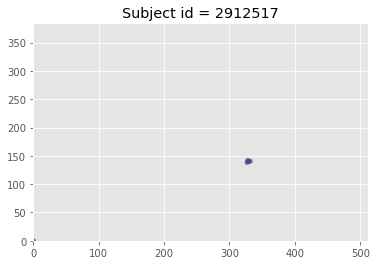

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


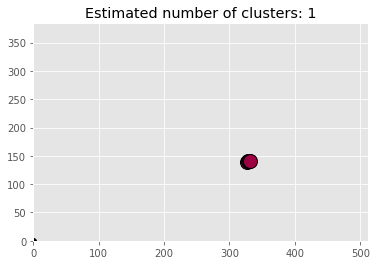

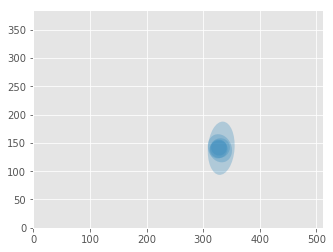

x_mean =  [329.11874999999998]
y_mean =  [140.38666992187501]
fringe_count_mean =  [2.7999999999999998]
rx_mean =  [48.23857646157083]
ry_mean =  [36.715680826202984]
angle_mean =  [-93.55372056677633]
averages =  [[329.11874999999998], [140.38666992187501], [2.7999999999999998], [48.23857646157083], [36.715680826202984], [-93.55372056677633]]
1

 average_list =  [[329.11874999999998, 140.38666992187501, '2912517', 2.7999999999999998, 48.23857646157083, 36.715680826202984, -93.55372056677633]]

 keepgood =  [[327, 138.4666748046875, '2912517', 2, 31.064449134018133, 33.301656650884766, -48.65221292611245], [329.5, 140.4666748046875, '2912517', 3, 51.10772935672255, 41.23105921681716, -67.16633605089488], [327.796875, 141.75, '2912517', 3, 28.635642126552707, 27.85677655436824, -248.96248897457818], [329.5, 140.75, '2912517', 3, 36.124783736376884, 34.058772731852805, -139.7636416907262], [331.796875, 140.5, '2912517', 3, 94.26027795418386, 47.13013897709193, -94.25884612217035]]
key = 

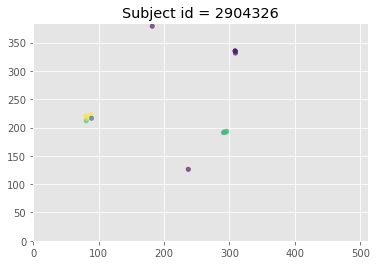

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


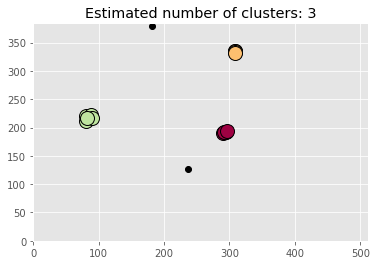

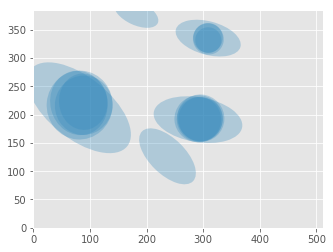

x_mean =  [293.2640441894531, 308.84358978271484, 84.056848144531244]
y_mean =  [192.14070129394531, 333.84488677978516, 217.66430053710937]
fringe_count_mean =  [7.5999999999999996, 1.5, 9.0]
rx_mean =  [96.78262485601303, 67.765238380678767, 131.04731453809879]
ry_mean =  [80.639611563121846, 52.917871084216003, 103.38045703664686]
angle_mean =  [97.89865493074416, 20.295384146808853, -50.24205713864872]
averages =  [[293.2640441894531, 308.84358978271484, 84.056848144531244], [192.14070129394531, 333.84488677978516, 217.66430053710937], [7.5999999999999996, 1.5, 9.0], [96.78262485601303, 67.765238380678767, 131.04731453809879], [80.639611563121846, 52.917871084216003, 103.38045703664686], [97.89865493074416, 20.295384146808853, -50.24205713864872]]
3

 average_list =  [[293.2640441894531, 192.14070129394531, '2904326', 7.5999999999999996, 96.78262485601303, 80.639611563121846, 97.89865493074416], [308.84358978271484, 333.84488677978516, '2904326', 1.5, 67.765238380678767, 52.9178710

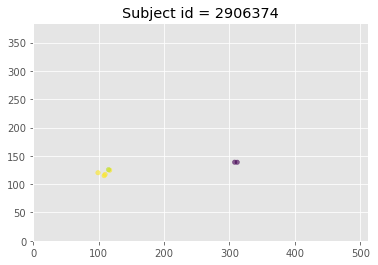

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


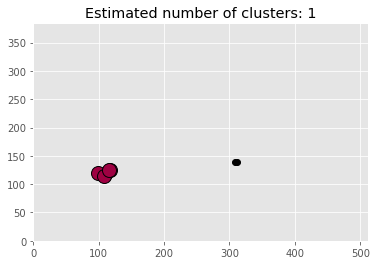

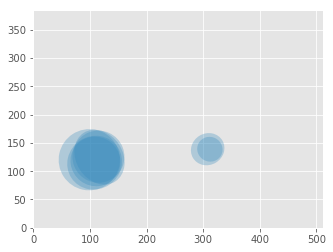

x_mean =  [109.74746704101562]
y_mean =  [120.55967407226562]
fringe_count_mean =  [10.800000000000001]
rx_mean =  [92.474484735345044]
ry_mean =  [98.111109948243978]
angle_mean =  [62.71448596810464]
averages =  [[109.74746704101562], [120.55967407226562], [10.800000000000001], [92.474484735345044], [98.111109948243978], [62.71448596810464]]
1

 average_list =  [[109.74746704101562, 120.55967407226562, '2906374', 10.800000000000001, 92.474484735345044, 98.111109948243978, 62.71448596810464]]

 keepgood =  [[116.796875, 124.75, '2906374', 11, 82.37718130647589, 102.41581909060729, 33.11134196037203], [109.77483367919922, 117.22232818603516, '2906374', 11, 86.6502784040607, 89.38942096216903, 52.63333058723131], [98.9000015258789, 120.21666717529297, '2906374', 11, 107.9351647350254, 108.45274828906021, -57.042572950163006], [108.296875, 115, '2906374', 11, 93.60021367496978, 98.18350166906862, -236.63363399894044], [114.96875, 125.609375, '2906374', 10, 91.80958555619343, 92.114059730

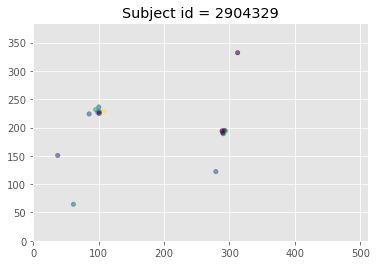

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


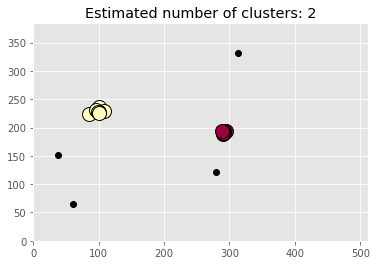

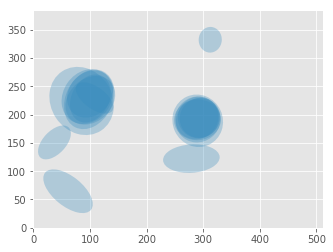

x_mean =  [291.03655497233075, 98.426310403006411]
y_mean =  [192.09091440836588, 228.80065264020647]
fringe_count_mean =  [4.333333333333333, 5.2857142857142856]
rx_mean =  [76.298541730402803, 96.239166735350054]
ry_mean =  [79.492748902734036, 78.25975225399084]
angle_mean =  [-49.27148841693001, -42.27208278212489]
averages =  [[291.03655497233075, 98.426310403006411], [192.09091440836588, 228.80065264020647], [4.333333333333333, 5.2857142857142856], [76.298541730402803, 96.239166735350054], [79.492748902734036, 78.25975225399084], [-49.27148841693001, -42.27208278212489]]
2

 average_list =  [[291.03655497233075, 192.09091440836588, '2904329', 4.333333333333333, 76.298541730402803, 79.492748902734036, -49.27148841693001], [98.426310403006411, 228.80065264020647, '2904329', 5.2857142857142856, 96.239166735350054, 78.25975225399084, -42.27208278212489]]

 keepgood =  [[290.296875, 189, '2904329', 7, 93.47726996441435, 88.59599313738742, -65.31519562673208], [85.296875, 224, '2904329

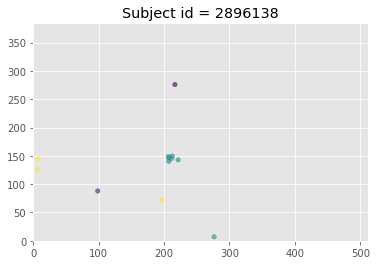

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


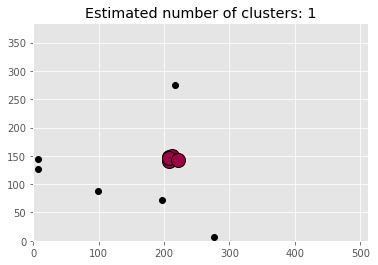

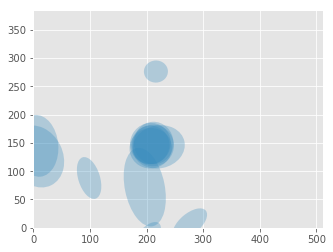

x_mean =  [211.09809112548828]
y_mean =  [145.64722442626953]
fringe_count_mean =  [5.833333333333333]
rx_mean =  [74.374072048339642]
ry_mean =  [73.419173168437496]
angle_mean =  [-118.21966970312144]
averages =  [[211.09809112548828], [145.64722442626953], [5.833333333333333], [74.374072048339642], [73.419173168437496], [-118.21966970312144]]
1

 average_list =  [[211.09809112548828, 145.64722442626953, '2896138', 5.833333333333333, 74.374072048339642, 73.419173168437496, -118.21966970312144]]

 keepgood =  [[211.6354217529297, 145.4166717529297, '2896138', 6, 73.43022570355639, 73.23932556908716, -55.00796806634992], [206.796875, 148.75, '2896138', 6, 71.58910531638176, 73.53910524340094, -28.35496178532406], [212.546875, 149.75, '2896138', 6, 70.06425622241343, 75.05997601918082, -177.54596832547293], [207.296875, 140.5, '2896138', 5, 71.386273190299, 74.96665925596525, -78.69006752597979], [206.8125, 146.5, '2896138', 6, 67.11929677819934, 68, 176.58341180822867], [221.5, 142.966

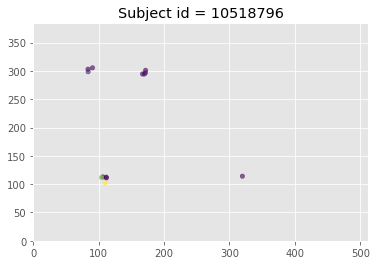

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


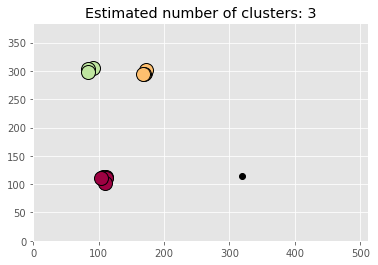

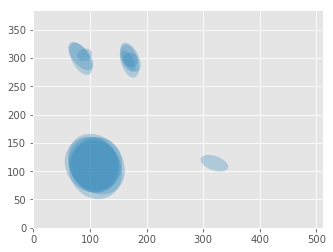

x_mean =  [108.65562438964844, 169.99140548706055, 85.998957316080734]
y_mean =  [110.0852066040039, 296.66901397705078, 302.35556030273438]
fringe_count_mean =  [4.5999999999999996, 1.25, 1.3333333333333333]
rx_mean =  [101.82076938734258, 45.97486558873311, 49.827237135275261]
ry_mean =  [92.636941133823854, 26.514887398790613, 27.449132698707952]
angle_mean =  [-84.105487947918, -1.1197990915914315, -32.62650632687675]
averages =  [[108.65562438964844, 169.99140548706055, 85.998957316080734], [110.0852066040039, 296.66901397705078, 302.35556030273438], [4.5999999999999996, 1.25, 1.3333333333333333], [101.82076938734258, 45.97486558873311, 49.827237135275261], [92.636941133823854, 26.514887398790613, 27.449132698707952], [-84.105487947918, -1.1197990915914315, -32.62650632687675]]
3

 average_list =  [[108.65562438964844, 110.0852066040039, '10518796', 4.5999999999999996, 101.82076938734258, 92.636941133823854, -84.105487947918], [169.99140548706055, 296.66901397705078, '10518796', 1

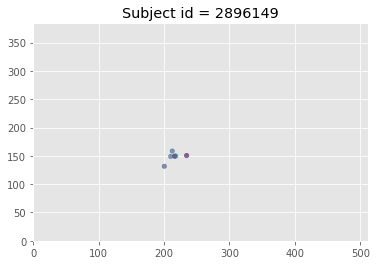

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


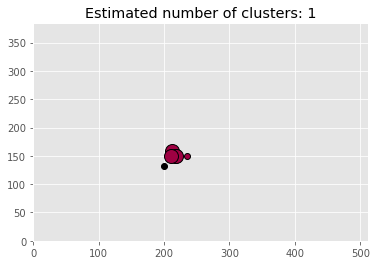

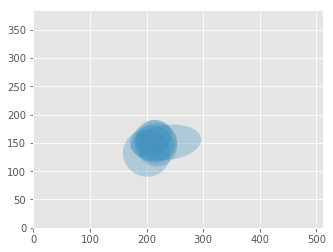

x_mean =  [214.07421875]
y_mean =  [151.67916107177734]
fringe_count_mean =  [3.5]
rx_mean =  [75.456189820723139]
ry_mean =  [66.877644440030082]
angle_mean =  [-95.45525328985553]
averages =  [[214.07421875], [151.67916107177734], [3.5], [75.456189820723139], [66.877644440030082], [-95.45525328985553]]
1

 average_list =  [[214.07421875, 151.67916107177734, '2896149', 3.5, 75.456189820723139, 66.877644440030082, -95.45525328985553]]

 keepgood =  [[212.5, 158.5333251953125, '2896149', 4, 67.26812023536856, 58.7962583843564, -131.5526131481348], [216, 149.46665954589844, '2896149', 1, 83.2586331859946, 74.84650960465692, -65.89776549883887], [217.796875, 149.75, '2896149', 5, 72.78049189171504, 70.22819946431775, -160.01689347810003], [210, 148.96665954589844, '2896149', 4, 78.5175139698144, 63.63961030678928, -8.130102354155966]]
key = coords2896150 value =  [[208.45106506347656, 149.01488494873047, '2896150', 4, 69.70803621635199, 66.98651720331696, -59.534489159609905], [21.6517391

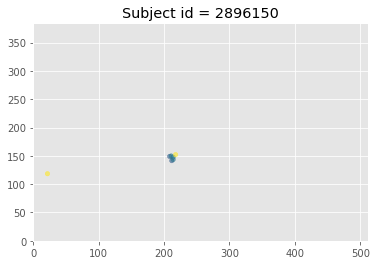

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


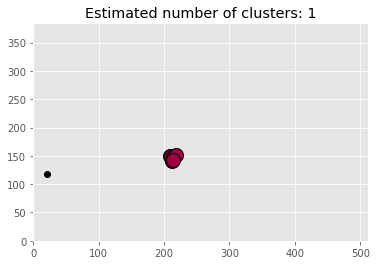

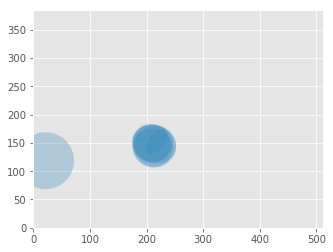

x_mean =  [212.70435333251953]
y_mean =  [147.28737767537436]
fringe_count_mean =  [5.666666666666667]
rx_mean =  [69.516314747734782]
ry_mean =  [61.630177682183081]
angle_mean =  [-19.97299977531269]
averages =  [[212.70435333251953], [147.28737767537436], [5.666666666666667], [69.516314747734782], [61.630177682183081], [-19.97299977531269]]
1

 average_list =  [[212.70435333251953, 147.28737767537436, '2896150', 5.666666666666667, 69.516314747734782, 61.630177682183081, -19.97299977531269]]

 keepgood =  [[208.45106506347656, 149.01488494873047, '2896150', 4, 69.70803621635199, 66.98651720331696, -59.534489159609905], [210.796875, 149.75, '2896150', 5, 72.56031973468694, 65.62011886609167, -7.883139316729725], [213.796875, 147.75, '2896150', 5, 77.87810988975015, 65.7419196555744, -26.17528998175993], [211.76138305664062, 141.5749053955078, '2896150', 4, 69.81694833925575, 67.26845977944252, -222.27369075459148], [217.623046875, 152.1344757080078, '2896150', 11, 53.34423104887083, 2

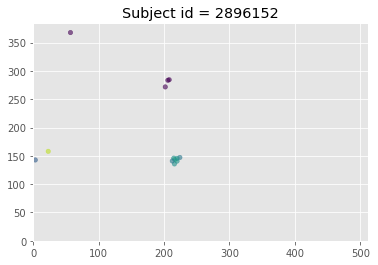

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


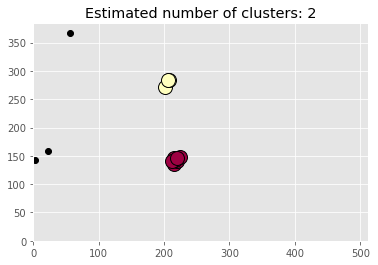

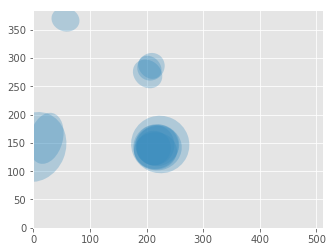

x_mean =  [217.6124986921038, 205.11411539713541]
y_mean =  [142.79761614118303, 279.89006551106769]
fringe_count_mean =  [5.8571428571428568, 1.0]
rx_mean =  [76.975024434495239, 50.355651782395654]
ry_mean =  [77.239879503185662, 43.281821763789878]
angle_mean =  [30.312525328593818, -15.649960016608949]
averages =  [[217.6124986921038, 205.11411539713541], [142.79761614118303, 279.89006551106769], [5.8571428571428568, 1.0], [76.975024434495239, 50.355651782395654], [77.239879503185662, 43.281821763789878], [30.312525328593818, -15.649960016608949]]
2

 average_list =  [[217.6124986921038, 142.79761614118303, '2896152', 5.8571428571428568, 76.975024434495239, 77.239879503185662, 30.312525328593818], [205.11411539713541, 279.89006551106769, '2896152', 1.0, 50.355651782395654, 43.281821763789878, -15.649960016608949]]

 keepgood =  [[214.796875, 146, '2896152', 6, 68.73136110975832, 71.56814934033156, -8.36588612403259], [215.796875, 135.75, '2896152', 6, 76, 66.007575322837, -0.868051

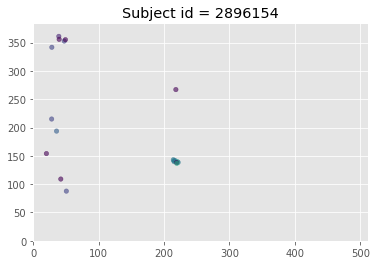

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


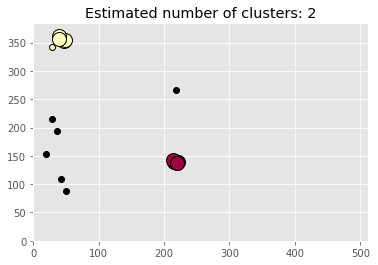

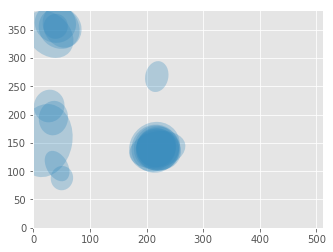

x_mean =  [217.68632698059082, 43.724218368530273]
y_mean =  [139.89083099365234, 356.17749786376953]
fringe_count_mean =  [4.875, 1.75]
rx_mean =  [80.24134459612381, 68.036713611504581]
ry_mean =  [76.933259451281643, 61.167825299806886]
angle_mean =  [-62.78087103160096, -38.99829371142025]
averages =  [[217.68632698059082, 43.724218368530273], [139.89083099365234, 356.17749786376953], [4.875, 1.75], [80.24134459612381, 68.036713611504581], [76.933259451281643, 61.167825299806886], [-62.78087103160096, -38.99829371142025]]
2

 average_list =  [[217.68632698059082, 139.89083099365234, '2896154', 4.875, 80.24134459612381, 76.933259451281643, -62.78087103160096], [43.724218368530273, 356.17749786376953, '2896154', 1.75, 68.036713611504581, 61.167825299806886, -38.99829371142025]]

 keepgood =  [[216.796875, 141.75, '2896154', 5, 68.09552114493287, 69.35416353759881, -222.6626941408762], [215, 141.4499969482422, '2896154', 5, 73.824115301167, 79.47955712005447, -24.8293465881496], [221.

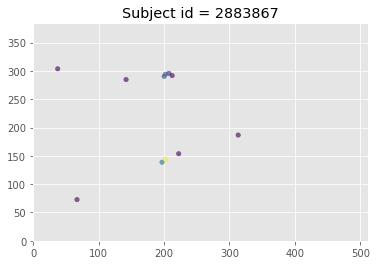

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


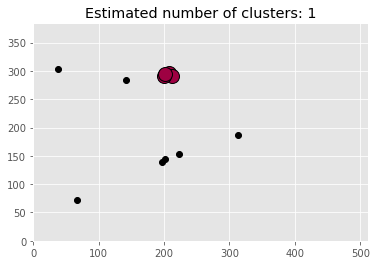

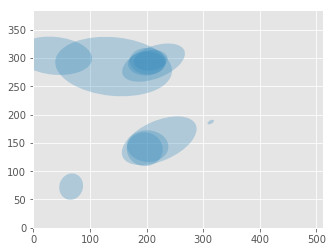

x_mean =  [206.53841654459634]
y_mean =  [292.60158284505206]
fringe_count_mean =  [2.0]
rx_mean =  [81.02228592979904]
ry_mean =  [45.164918649995705]
angle_mean =  [10.54783679789628]
averages =  [[206.53841654459634], [292.60158284505206], [2.0], [81.02228592979904], [45.164918649995705], [10.54783679789628]]
1

 average_list =  [[206.53841654459634, 292.60158284505206, '2883867', 2.0, 81.02228592979904, 45.164918649995705, 10.54783679789628]]

 keepgood =  [[207.296875, 295.75, '2883867', 2, 60.207972893961475, 36.345563690772494, 7.907162702958459], [212.296875, 291.75, '2883867', 1, 116.81181447096864, 56.64803615307419, 21.072726619950554], [200.02149963378906, 290.30474853515625, '2883867', 3, 66.047070424467, 42.50115610614043, 2.697235895610717]]
key = coords2883869 value =  [[210.296875, 144, '2883869', 9, 78.85429601486528, 64.19501538281614, 18.152705886651162], [1.296875, 151, '2883869', 10, 89.02246907382428, 72.00694410957877, -89.20427644726072], [207.37960815429688, 1

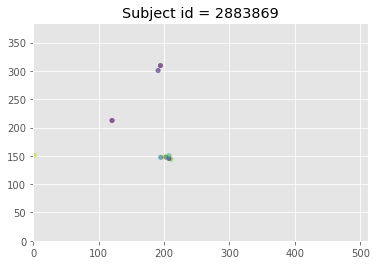

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


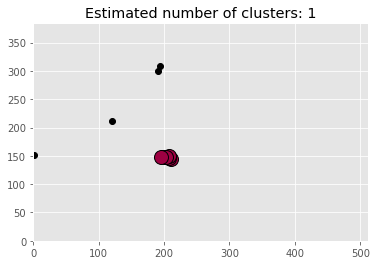

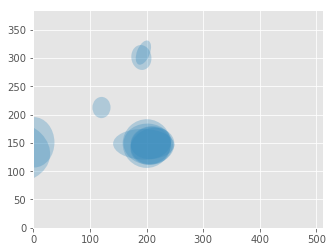

x_mean =  [203.87097676595053]
y_mean =  [147.30385589599609]
fringe_count_mean =  [6.666666666666667]
rx_mean =  [80.430992282625439]
ry_mean =  [70.065690812895454]
angle_mean =  [28.703172180636976]
averages =  [[203.87097676595053], [147.30385589599609], [6.666666666666667], [80.430992282625439], [70.065690812895454], [28.703172180636976]]
1

 average_list =  [[203.87097676595053, 147.30385589599609, '2883869', 6.666666666666667, 80.430992282625439, 70.065690812895454, 28.703172180636976]]

 keepgood =  [[210.296875, 144, '2883869', 9, 78.85429601486528, 64.19501538281614, 18.152705886651162], [207.37960815429688, 145.40948486328125, '2883869', 2, 65.3007575485855, 71.84168896962606, -253.8355006783486], [207.5, 150.46665954589844, '2883869', 8, 71.84705978674423, 57.87054518492115, 9.950626687951612], [200.296875, 148.75, '2883869', 11, 86, 85.05292469985967, 87.978635059644], [202.796875, 147.75, '2883869', 5, 72.44998274671983, 87.36704184073076, -95.25380275126226], [194.955627

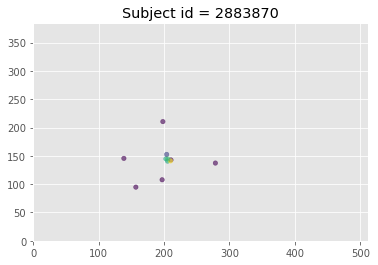

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


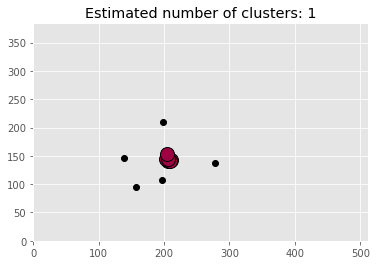

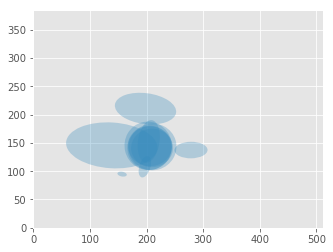

x_mean =  [206.336789449056]
y_mean =  [144.41055806477866]
fringe_count_mean =  [6.166666666666667]
rx_mean =  [76.651982211584198]
ry_mean =  [72.838110517883351]
angle_mean =  [17.01378981317388]
averages =  [[206.336789449056], [144.41055806477866], [6.166666666666667], [76.651982211584198], [72.838110517883351], [17.01378981317388]]
1

 average_list =  [[206.336789449056, 144.41055806477866, '2883870', 6.166666666666667, 76.651982211584198, 72.838110517883351, 17.01378981317388]]

 keepgood =  [[205.296875, 140.75, '2883870', 7, 77.07788269017254, 78.74642849044012, -72.25532837494306], [202.796875, 144.75, '2883870', 7, 85.72630868059116, 83.43260753446461, -256.130313561495], [210.5, 142.75, '2883870', 1, 82.28000972289685, 84.77027781009096, -73.7676493388438], [209.6999969482422, 141.09999084472656, '2883870', 11, 68.02939778068304, 74.10802925459562, -266.9059419410829], [205.796875, 144.5, '2883870', 8, 71.17583859709698, 78.16009211867653, 85.97173633351487], [203.930114746

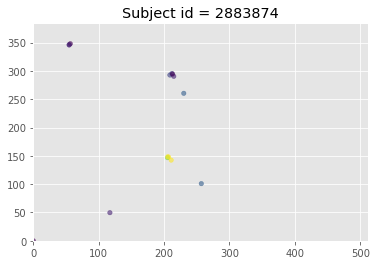

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


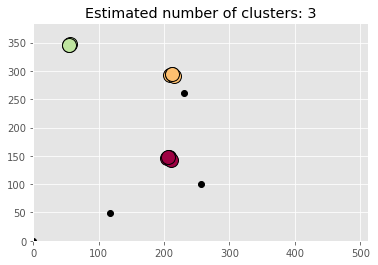

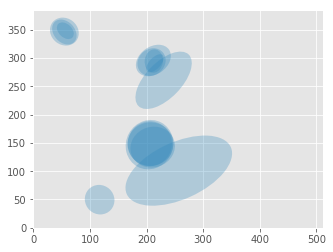

x_mean =  [207.13034439086914, 212.09503936767578, 55.372563680013023]
y_mean =  [146.396240234375, 293.29795837402344, 346.75858561197919]
fringe_count_mean =  [10.5, 2.25, 1.6666666666666667]
rx_mean =  [80.712502229072442, 50.166378996773304, 45.767364686691401]
ry_mean =  [78.673573173018724, 36.714870013889112, 35.791191895849494]
angle_mean =  [-167.093834300508, -32.75320229181495, -42.9870818296364]
averages =  [[207.13034439086914, 212.09503936767578, 55.372563680013023], [146.396240234375, 293.29795837402344, 346.75858561197919], [10.5, 2.25, 1.6666666666666667], [80.712502229072442, 50.166378996773304, 45.767364686691401], [78.673573173018724, 36.714870013889112, 35.791191895849494], [-167.093834300508, -32.75320229181495, -42.9870818296364]]
3

 average_list =  [[207.13034439086914, 146.396240234375, '2883874', 10.5, 80.712502229072442, 78.673573173018724, -167.093834300508], [212.09503936767578, 293.29795837402344, '2883874', 2.25, 50.166378996773304, 36.714870013889112, -

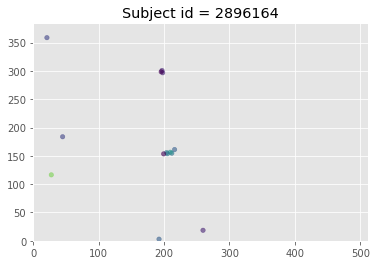

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


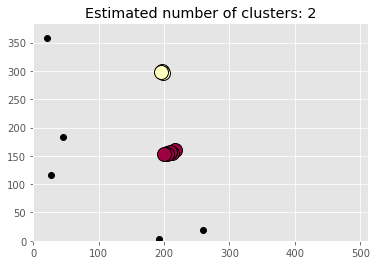

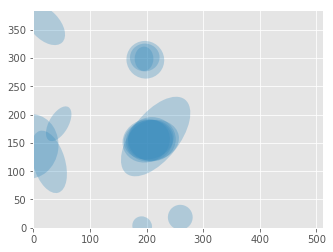

x_mean =  [207.55186971028647, 196.69791666666666]
y_mean =  [155.89102172851562, 298.65555826822919]
fringe_count_mean =  [4.333333333333333, 1.6666666666666667]
rx_mean =  [95.668778799973609, 53.697869700474193]
ry_mean =  [79.306659678619823, 49.816335770243313]
angle_mean =  [-29.294637868779724, -6.280148465112669]
averages =  [[207.55186971028647, 196.69791666666666], [155.89102172851562, 298.65555826822919], [4.333333333333333, 1.6666666666666667], [95.668778799973609, 53.697869700474193], [79.306659678619823, 49.816335770243313], [-29.294637868779724, -6.280148465112669]]
2

 average_list =  [[207.55186971028647, 155.89102172851562, '2896164', 4.333333333333333, 95.668778799973609, 79.306659678619823, -29.294637868779724], [196.69791666666666, 298.65555826822919, '2896164', 1.6666666666666667, 53.697869700474193, 49.816335770243313, -6.280148465112669]]

 keepgood =  [[216.02059936523438, 161.17947387695312, '2896164', 4, 166.69346230780758, 83.34673115390379, 51.5569483403305

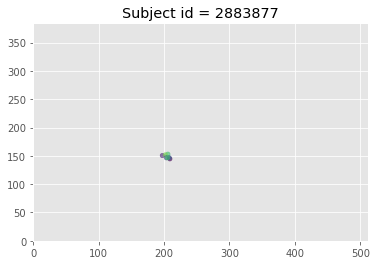

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


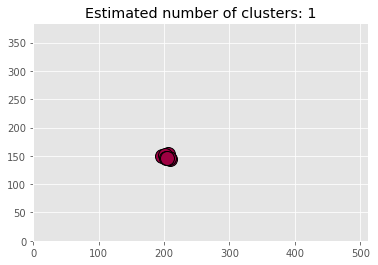

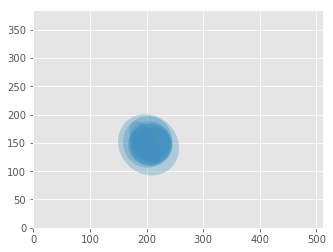

x_mean =  [204.28668212890625]
y_mean =  [148.57887540544783]
fringe_count_mean =  [5.0]
rx_mean =  [82.881055695282157]
ry_mean =  [74.550006585375101]
angle_mean =  [-62.87720969504501]
averages =  [[204.28668212890625], [148.57887540544783], [5.0], [82.881055695282157], [74.550006585375101], [-62.87720969504501]]
1

 average_list =  [[204.28668212890625, 148.57887540544783, '2883877', 5.0, 82.881055695282157, 74.550006585375101, -62.87720969504501]]

 keepgood =  [[205.796875, 153, '2883877', 8, 69.8927750200262, 73.40980860893181, 65.87901688055743], [208.796875, 144.75, '2883877', 1, 73.68174807915459, 65.52098900352466, -164.05460409907715], [197.29293823242188, 150.60174560546875, '2883877', 2, 83.6104723691864, 41.8052361845932, -59.88626956255018], [207.6999969482422, 146.75, '2883877', 4, 76.15773105863909, 76.02629758711731, -63.434943680190415], [201.9825897216797, 151.73163223266602, '2883877', 9, 87.02454215611763, 91.08400849212151, -8.841810661059839], [203.46875, 146.6

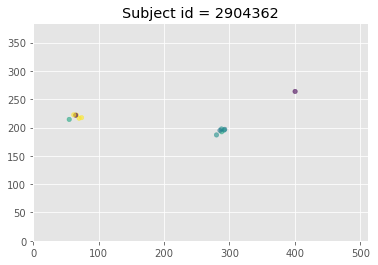

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


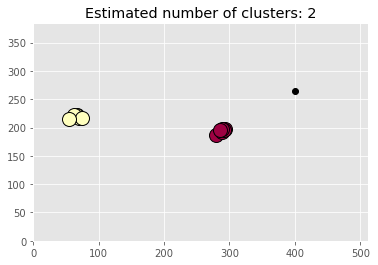

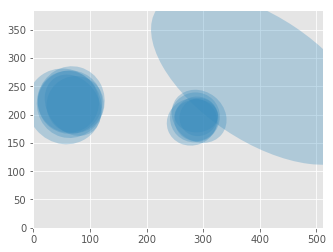

x_mean =  [287.6561330159505, 65.221759796142578]
y_mean =  [194.04241689046225, 219.10395304361978]
fringe_count_mean =  [5.833333333333333, 8.6666666666666661]
rx_mean =  [81.215492122929206, 116.94072315272757]
ry_mean =  [79.669491474178002, 110.63957283385032]
angle_mean =  [10.579339014268557, -45.39895666531496]
averages =  [[287.6561330159505, 65.221759796142578], [194.04241689046225, 219.10395304361978], [5.833333333333333, 8.6666666666666661], [81.215492122929206, 116.94072315272757], [79.669491474178002, 110.63957283385032], [10.579339014268557, -45.39895666531496]]
2

 average_list =  [[287.6561330159505, 194.04241689046225, '2904362', 5.833333333333333, 81.215492122929206, 79.669491474178002, 10.579339014268557], [65.221759796142578, 219.10395304361978, '2904362', 8.6666666666666661, 116.94072315272757, 110.63957283385032, -45.39895666531496]]

 keepgood =  [[280.1000061035156, 186.9499969482422, '2904362', 6, 89.5377015563835, 82.87339742040264, 19.746836605426125], [66.0

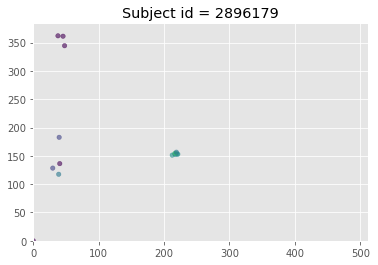

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


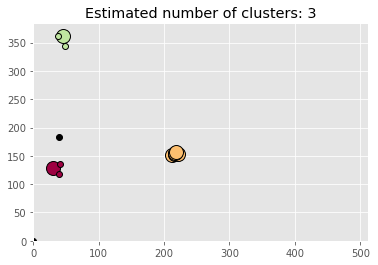

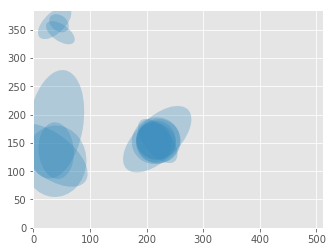

/Users/amorriso/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/amorriso/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/amorriso/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:951: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


x_mean =  [217.45863124302454, nan]
y_mean =  [153.56348964146204, nan]
fringe_count_mean =  [5.8571428571428568, nan]
rx_mean =  [87.506173126659164, nan]
ry_mean =  [69.586372537850735, nan]
angle_mean =  [-9.836350217278493, nan]
averages =  [[217.45863124302454, nan], [153.56348964146204, nan], [5.8571428571428568, nan], [87.506173126659164, nan], [69.586372537850735, nan], [-9.836350217278493, nan]]
2

 average_list =  [[217.45863124302454, 153.56348964146204, '2896179', 5.8571428571428568, 87.506173126659164, 69.586372537850735, -9.836350217278493], [nan, nan, '2896179', nan, nan, nan, nan]]

 keepgood =  [[29.700000762939453, 128.39999389648438, '2896179', 3, 154.9999969482422, 77.4999984741211, -36.869898491906184], [219.6999969482422, 153.39999389648438, '2896179', 5, 93.7230058793193, 46.86150293965965, -50.19442174163544], [212.4166717529297, 151.3000030517578, '2896179', 6, 62.96826098988344, 72.56031973468694, 7.125016348901809], [45.41667175292969, 361.29998779296875, '28

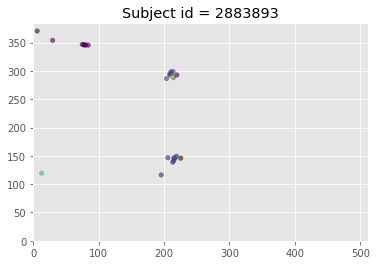

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


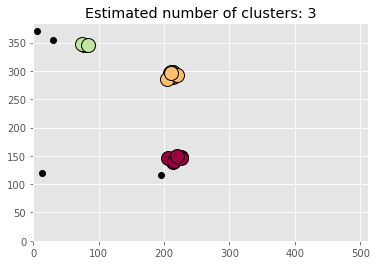

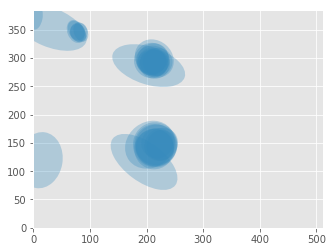

x_mean =  [216.91453721788196, 211.53110046386718, 78.867474365234372]
y_mean =  [145.46480984157986, 293.35402526855466, 346.04538574218748]
fringe_count_mean =  [3.4444444444444446, 3.7000000000000002, 1.0]
rx_mean =  [69.639164245691859, 63.84203405707202, 36.538744392128947]
ry_mean =  [67.201629977746222, 54.977031725764299, 27.666129011930614]
angle_mean =  [63.81529391187491, -36.776500115951336, -39.14023725996937]
averages =  [[216.91453721788196, 211.53110046386718, 78.867474365234372], [145.46480984157986, 293.35402526855466, 346.04538574218748], [3.4444444444444446, 3.7000000000000002, 1.0], [69.639164245691859, 63.84203405707202, 36.538744392128947], [67.201629977746222, 54.977031725764299, 27.666129011930614], [63.81529391187491, -36.776500115951336, -39.14023725996937]]
3

 average_list =  [[216.91453721788196, 145.46480984157986, '2883893', 3.4444444444444446, 69.639164245691859, 67.201629977746222, 63.81529391187491], [211.53110046386718, 293.35402526855466, '2883893',

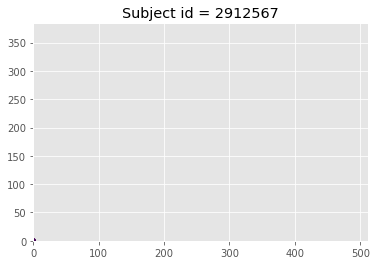

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


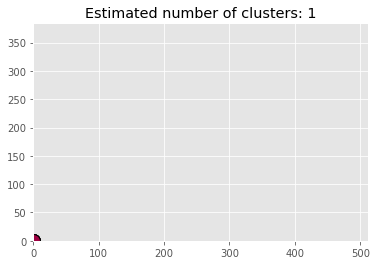

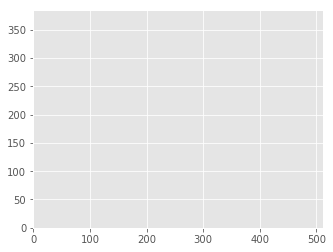

x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '2912567', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '2912567', 0, 0, 0, 0], [0, 0, '2912567', 0, 0, 0, 0], [0, 0, '2912567', 0, 0, 0, 0], [0, 0, '2912567', 0, 0, 0, 0], [0, 0, '2912567', 0, 0, 0, 0], [0, 0, '2912567', 0, 0, 0, 0]]
key = coords2883896 value =  [[211.279541015625, 154.63897705078125, '2883896', 8, 73.27242027132036, 77.22547691986259, -34.24903636433726], [210.82229614257812, 151.13690185546875, '2883896', 8, 79.37063070262688, 76.45325407029887, 2.009556018471983], [230.92919921875, 290.5447692871094, '2883896', 1, 53.91917649712322, 57.99717433272781, -123.69007588767218], [349.399658203125, 165.99668884277344, '2883896', None, 0, 0, 0], [210.14927673339844, 154.1094512939453, '2883896', 6, 64.55302049542536, 68.45565463030506, -133.9949288850836], [204.39083862304688, 1

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


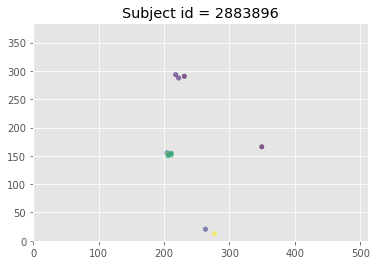

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


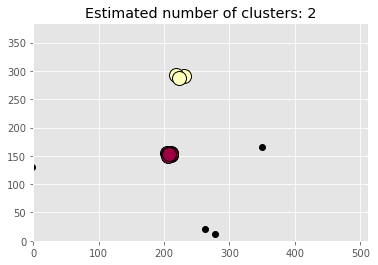

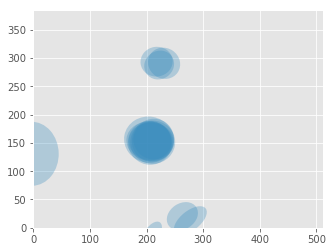

x_mean =  [208.01221139090401, 223.61028035481772]
y_mean =  [152.97052546909876, 290.46286010742188]
fringe_count_mean =  [7.2857142857142856, 1.6666666666666667]
rx_mean =  [76.12036335844013, 53.463164059407177]
ry_mean =  [75.674071876725833, 54.850617098541939]
angle_mean =  [-54.38814179178759, -57.013982004293446]
averages =  [[208.01221139090401, 223.61028035481772], [152.97052546909876, 290.46286010742188], [7.2857142857142856, 1.6666666666666667], [76.12036335844013, 53.463164059407177], [75.674071876725833, 54.850617098541939], [-54.38814179178759, -57.013982004293446]]
2

 average_list =  [[208.01221139090401, 152.97052546909876, '2883896', 7.2857142857142856, 76.12036335844013, 75.674071876725833, -54.38814179178759], [223.61028035481772, 290.46286010742188, '2883896', 1.6666666666666667, 53.463164059407177, 54.850617098541939, -57.013982004293446]]

 keepgood =  [[211.279541015625, 154.63897705078125, '2883896', 8, 73.27242027132036, 77.22547691986259, -34.24903636433726]

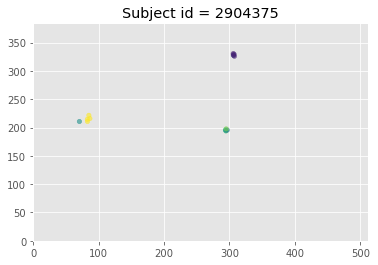

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


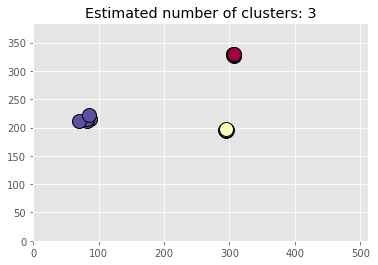

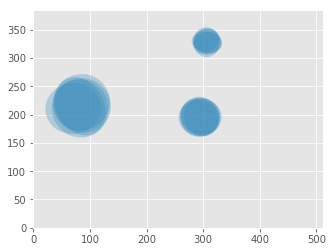

x_mean =  [306.43916625976561, 294.89247741699216, 81.473623657226568]
y_mean =  [328.32854614257815, 195.59659729003906, 214.71856384277345]
fringe_count_mean =  [2.2000000000000002, 7.0, 10.0]
rx_mean =  [45.803872678853537, 69.476365543563432, 100.76973753302687]
ry_mean =  [46.520593953541983, 66.172282203168038, 95.476233042129721]
angle_mean =  [-0.19833764006007507, 8.671055774852869, 3.186863948989724]
averages =  [[306.43916625976561, 294.89247741699216, 81.473623657226568], [328.32854614257815, 195.59659729003906, 214.71856384277345], [2.2000000000000002, 7.0, 10.0], [45.803872678853537, 69.476365543563432, 100.76973753302687], [46.520593953541983, 66.172282203168038, 95.476233042129721], [-0.19833764006007507, 8.671055774852869, 3.186863948989724]]
3

 average_list =  [[306.43916625976561, 328.32854614257815, '2904375', 2.2000000000000002, 45.803872678853537, 46.520593953541983, -0.19833764006007507], [294.89247741699216, 195.59659729003906, '2904375', 7.0, 69.47636554356343

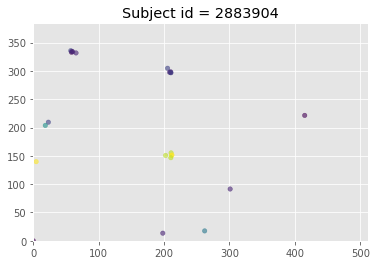

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


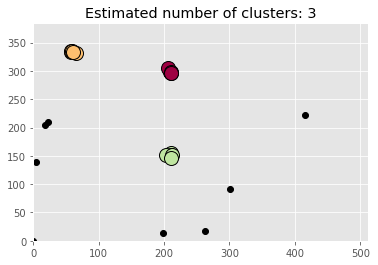

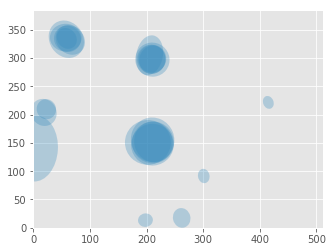

x_mean =  [208.83750000000001, 60.037500000000001, 209.31228332519532]
y_mean =  [298.94333496093748, 333.74333496093749, 151.00692138671874]
fringe_count_mean =  [2.3999999999999999, 2.0, 10.4]
rx_mean =  [55.668614654747543, 53.589637487516995, 75.65426235963983]
ry_mean =  [51.442989157991676, 47.146146210872885, 74.861612104099663]
angle_mean =  [-32.565522199392795, -36.91633501805578, -46.423001492874796]
averages =  [[208.83750000000001, 60.037500000000001, 209.31228332519532], [298.94333496093748, 333.74333496093749, 151.00692138671874], [2.3999999999999999, 2.0, 10.4], [55.668614654747543, 53.589637487516995, 75.65426235963983], [51.442989157991676, 47.146146210872885, 74.861612104099663], [-32.565522199392795, -36.91633501805578, -46.423001492874796]]
3

 average_list =  [[208.83750000000001, 298.94333496093748, '2883904', 2.3999999999999999, 55.668614654747543, 51.442989157991676, -32.565522199392795], [60.037500000000001, 333.74333496093749, '2883904', 2.0, 53.5896374875169

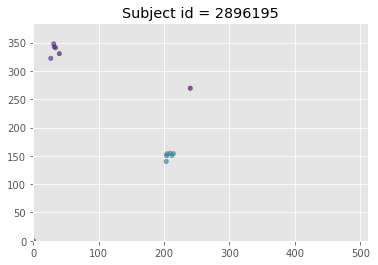

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


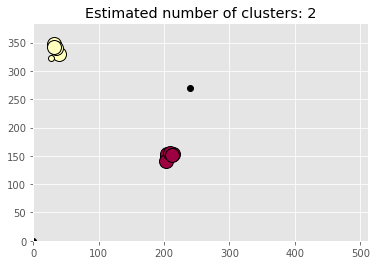

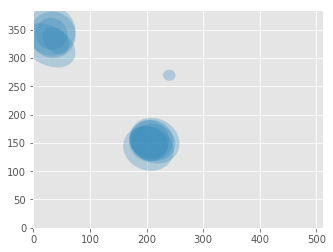

x_mean =  [207.70082600911459, 34.294269561767578]
y_mean =  [150.57416788736978, 340.40000152587891]
fringe_count_mean =  [5.166666666666667, 1.75]
rx_mean =  [76.593280829799284, 69.76725602399064]
ry_mean =  [73.073003280578689, 66.380460542167313]
angle_mean =  [96.65075574782703, -6.0617205466781225]
averages =  [[207.70082600911459, 34.294269561767578], [150.57416788736978, 340.40000152587891], [5.166666666666667, 1.75], [76.593280829799284, 69.76725602399064], [73.073003280578689, 66.380460542167313], [96.65075574782703, -6.0617205466781225]]
2

 average_list =  [[207.70082600911459, 150.57416788736978, '2896195', 5.166666666666667, 76.593280829799284, 73.073003280578689, 96.65075574782703], [34.294269561767578, 340.40000152587891, '2896195', 1.75, 69.76725602399064, 66.380460542167313, -6.0617205466781225]]

 keepgood =  [[203.796875, 150.5, '2896195', 4, 70.57619995437555, 55.036351623268054, -20.74608027568341], [39.796875, 330.5, '2896195', 1, 54.644304369257, 39.62322551231

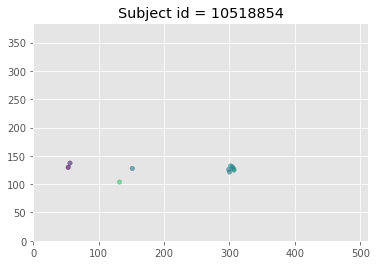

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


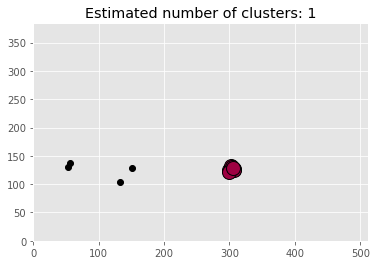

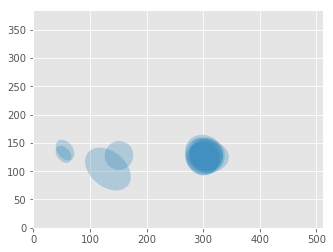

x_mean =  [303.3812473842076]
y_mean =  [127.05237906319755]
fringe_count_mean =  [5.8571428571428568]
rx_mean =  [65.546954088921808]
ry_mean =  [58.191287720777545]
angle_mean =  [-60.86629060424524]
averages =  [[303.3812473842076], [127.05237906319755], [5.8571428571428568], [65.546954088921808], [58.191287720777545], [-60.86629060424524]]
1

 average_list =  [[303.3812473842076, 127.05237906319755, '10518854', 5.8571428571428568, 65.546954088921808, 58.191287720777545, -60.86629060424524]]

 keepgood =  [[298.796875, 125.75, '10518854', 5, 67.11929677819934, 58.66856057549052, -61.52579638992563], [306.796875, 126.75, '10518854', 8, 62.6418390534633, 63.631753079732135, -30.19162296095761], [306.796875, 124.75, '10518854', 6, 77.31752712031083, 56.00892785976178, -178.97696981133217], [301.6999816894531, 132.14999389648438, '10518854', 6, 69.40459397911326, 61.85466837676846, -214.46081627137178], [304.265625, 130.75, '10518854', 5, 62.93647591023825, 53.009433122794285, -45.64374

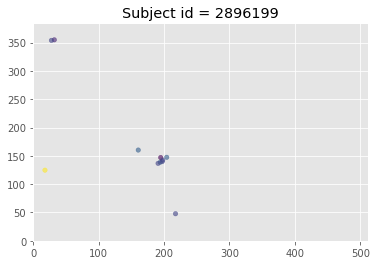

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


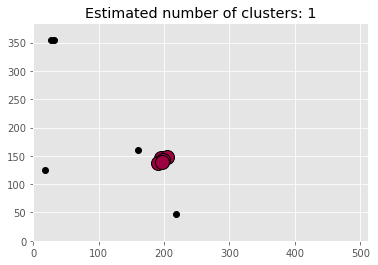

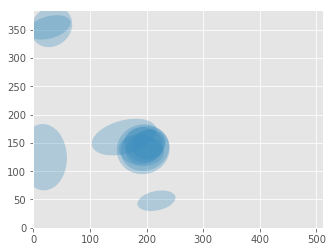

x_mean =  [196.41510264078775]
y_mean =  [142.06277720133463]
fringe_count_mean =  [3.0]
rx_mean =  [75.71298758430693]
ry_mean =  [66.789288357859434]
angle_mean =  [14.782042714566428]
averages =  [[196.41510264078775], [142.06277720133463], [3.0], [75.71298758430693], [66.789288357859434], [14.782042714566428]]
1

 average_list =  [[196.41510264078775, 142.06277720133463, '2896199', 3.0, 75.71298758430693, 66.789288357859434, 14.782042714566428]]

 keepgood =  [[194.796875, 147, '2896199', 1, 68.96375859826666, 61.98386886924694, -17.850318302216834], [204, 147.46665954589844, '2896199', 4, 51.478150704935004, 61.29437168288782, -241.76255446183274], [194, 138.760009765625, '2896199', 4, 93.92017887546851, 87.80091115700337, 14.511059500169068], [190.796875, 136.75, '2896199', 3, 80.05623023850174, 55.44366510251645, -7.2531946127253235], [197.796875, 142.5, '2896199', 3, 72.49827584156743, 56.824290580701486, -151.6309537067214], [197.09999084472656, 139.89999389648438, '2896199', 

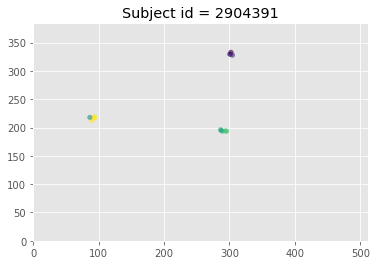

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


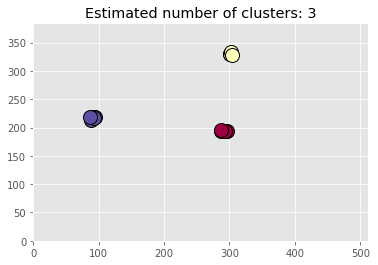

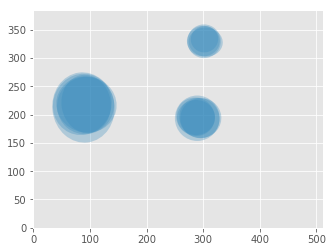

x_mean =  [290.47187500000001, 302.140625, 90.871875000000003]
y_mean =  [194.39333496093749, 330.05416870117188, 216.59333496093751]
fringe_count_mean =  [7.5999999999999996, 1.75, 10.0]
rx_mean =  [72.474496944166432, 56.544775600940994, 107.39606583472985]
ry_mean =  [69.506507305117879, 52.720272975170232, 101.60822368099842]
angle_mean =  [-59.46634255451508, -13.899724720432918, -71.02059688081744]
averages =  [[290.47187500000001, 302.140625, 90.871875000000003], [194.39333496093749, 330.05416870117188, 216.59333496093751], [7.5999999999999996, 1.75, 10.0], [72.474496944166432, 56.544775600940994, 107.39606583472985], [69.506507305117879, 52.720272975170232, 101.60822368099842], [-59.46634255451508, -13.899724720432918, -71.02059688081744]]
3

 average_list =  [[290.47187500000001, 194.39333496093749, '2904391', 7.5999999999999996, 72.474496944166432, 69.506507305117879, -59.46634255451508], [302.140625, 330.05416870117188, '2904391', 1.75, 56.544775600940994, 52.720272975170232

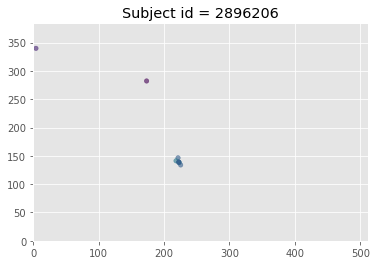

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


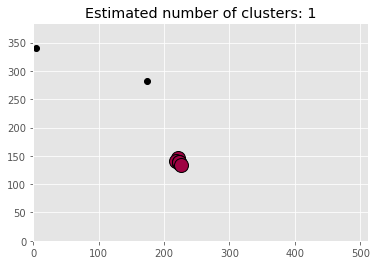

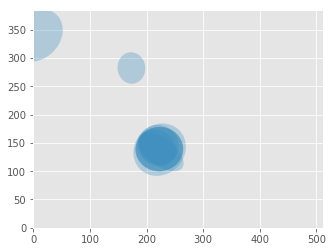

x_mean =  [222.20094735281808]
y_mean =  [139.50694710867745]
fringe_count_mean =  [4.2857142857142856]
rx_mean =  [81.448175498877504]
ry_mean =  [73.846037355805791]
angle_mean =  [17.094121645048567]
averages =  [[222.20094735281808], [139.50694710867745], [4.2857142857142856], [81.448175498877504], [73.846037355805791], [17.094121645048567]]
1

 average_list =  [[222.20094735281808, 139.50694710867745, '2896206', 4.2857142857142856, 81.448175498877504, 73.846037355805791, 17.094121645048567]]

 keepgood =  [[222.5, 138.96665954589844, '2896206', 4, 78.10249675906654, 84.01190391843289, 92.93567344642118], [221.296875, 146.5, '2896206', 4, 72.62231062146122, 69.02897942168927, -38.530180014826826], [218.25, 141.25, '2896206', 5, 71.40028011149536, 61.40032573203501, -37.05652818940958], [223.0397491455078, 137.94863891601562, '2896206', 5, 97.60523667334088, 87.35628917729484, -135.48147199033804], [222.5, 138.96665954589844, '2896206', 4, 78.10249675906654, 84.01190391843289, 92.93

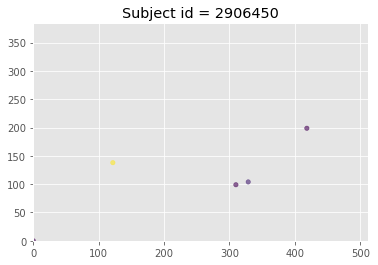

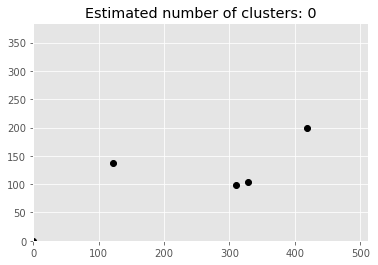

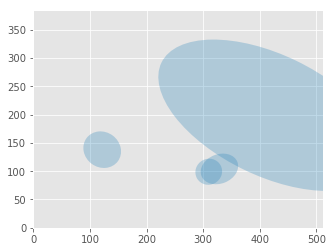

IndexError: too many indices for array

In [190]:
for key, value in d.items():
    #print(len(value))
    if len(value)  >0 and value[0][0] != 'None':
#    if len(value)  >0 and None not in value[key]:
        print("key =",key,"value = ", value,"\n")
    #if len(d.items()) > 0:
#        df_to_center_plt("{}".format(key))
        df_to_center_plt(value)
 
    #df_to_center_plt(key)

## For testing purposes - may delete later:

In [12]:
if len(parsed_json)==2:
    for i in range(len(parsed_json[1]['value'])):
        print(parsed_json[1]['value'][i]['x'])
        
elif len(parsed_json)==1:
    print("No antinodes found!")

No antinodes found!


In [13]:
print(parsed_json[1]['value'][0]['angle'])

IndexError: list index out of range

In [ ]:
i=len(data)

In [ ]:
i=len(data)
test_parsed_json = json.loads(data[i-2][11])
print(data[i-2][11],"\n")
print(test_parsed_json,"\n")
print(test_parsed_json[1]['value'][0]['angle'],"\n")
print(test_parsed_json[1]['value'],"\n")
print(test_parsed_json[1]['value'][0]['details'][0]['value'],"\n")
for j in range(len(test_parsed_json[1]['value'])):
    print("Fringe count = ",test_parsed_json[1]['value'][j]['details'][0]['value'],"\n")


In [ ]:
subject_id = data[i][13]
print(data[i][13])
print(subject_id)

In [9]:
import itertools
a = [1, 2, 3, 4, 5, 6]
result = itertools.filterfalse(lambda x : x == 3, a) # Output: 
for each in result:
    print(each)

1
2
4
5
6


## Debugging - may remove when done:

In [15]:
ell

NameError: name 'ell' is not defined

In [129]:
allsubjectids = []
for i in range(len(data)):
    allsubjectids.append(int(data[i][13]))
uniquesubjectids = (set(allsubjectids))
len(uniquesubjectids)

493

In [ ]:
for i in range(len(data)):
    #parsed_json = json.loads(data[i][13])
    #print(parsed_json)
    print(data[i][13])

In [40]:
with open("all-good-ellipses.csv") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    keepgood = [r for r in reader]
    


array(['209', '144.760009765625', '2883584', '1', '85.44003745317531',
       '42.720018726587654', '-20.556045219583467'], 
      dtype='<U19')

In [72]:
print(keepgood[1216])
print(results[1215])
print(len(keepgood))
print(len(results))

['205.5', '145.75', '2884169', '10', '78.29431652425353', '75.15317691222374', '-25.20112364547508']
[205.5, 145.75, 2884169, 10, 78.29431652425353, 75.15317691222374, -25.20112364547508]
4378
4373


In [77]:
results = []
for i in range(len(keepgood)):
    try:
        results.append([float(keepgood[i][0]),float(keepgood[i][1]),int(keepgood[i][2]),int(keepgood[i][3]),float(keepgood[i][4]),float(keepgood[i][5]),float(keepgood[i][6])])
    except ValueError:
        pass      # or whatever
    
#print(results)

X_avg = np.array(results)
print(X_avg[0])

X_avg = X_avg[:,[0,1]]
print(X_avg[0])

[  2.09000000e+02   1.44760010e+02   2.88358400e+06   1.00000000e+00
   8.54400375e+01   4.27200187e+01  -2.05560452e+01]
[ 209.          144.76000977]


In [171]:
def dbscan_average(keepgood):
    
    gooddata = []
    for i in range(len(keepgood)):
        try:
            gooddata.append([float(keepgood[i][0]),float(keepgood[i][1]),int(keepgood[i][2]),int(keepgood[i][3]),float(keepgood[i][4]),float(keepgood[i][5]),float(keepgood[i][6])])
        except ValueError:
            pass      # or whatever

    #print("gooddata = ",gooddata)
    bad_xy = []  #might need to change this
    X = np.array(gooddata)
    #X = X[:,[0,1]]
    db = DBSCAN(eps=18, min_samples=3).fit(X[:,[0,1]])
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    #fig = plt.figure(1)
    #ax = fig.add_subplot(212, aspect='equal')
    x_mean = []
    y_mean = []
    fringe_count_mean = []
    rx_mean = []
    ry_mean = []
    angle_mean = []
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        x = []
        y = []
        fringe_count = []
        rx = []
        ry = []
        angle = []
        
        class_member_mask = (labels == k)
        #print("class_member_mask =",class_member_mask)
        # These are the definitely "good" xy values.
        xy = X[class_member_mask & core_samples_mask]
        #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
        #         markeredgecolor='k', markersize=14)
        #print("k = ",k)
        for each in range(len(xy)):
            #print("x = ",xy[each][0])
            x.append(xy[each][0])
            #print("y = ",xy[each][1])
            y.append(xy[each][1])
            #print("fringe_count = ",xy[each][3])
            fringe_count.append(xy[each][3])
            #print("rx = ",xy[each][4])
            rx.append(xy[each][4])
            #print("ry = ",xy[each][5])
            ry.append(xy[each][5])
            #print("angle = ",xy[each][6])
            angle.append(xy[each][6])
        x_mean.append(np.mean(x))
        y_mean.append(np.mean(y))
        fringe_count_mean.append(np.mean(fringe_count))
        rx_mean.append(np.mean(rx))
        ry_mean.append(np.mean(ry))
        angles = np.array(angle)*u.deg
        angle_mean.append(circmean(angles).value)
        #angle_mean = [x / 2 for x in angle_mean]
        #print("\n Good? xy = ",xy)
        #print("X = ",X)
        # These are the "bad" xy values. Note that some maybe-bad and maybe-good are included here.
        xy = X[class_member_mask & ~core_samples_mask]
        #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
        #         markeredgecolor='k', markersize=6)
        #print("\n Bad? xy = ",xy)
        bad_xy.append(xy)

#    plt.title('From average - Estimated number of clusters: %d' % n_clusters_)
#    plt.xlim(0, 512)
#    plt.ylim(0, 384)
    print("x_mean = ",x_mean)
    print("y_mean = ",y_mean)
    print("fringe_count_mean = ",fringe_count_mean)
    print("rx_mean = ",rx_mean)
    print("ry_mean = ",ry_mean)
    
    print("angle_mean = ",angle_mean)
    
    averages = [x_mean,y_mean,fringe_count_mean,rx_mean,ry_mean,angle_mean]
    
    return averages

In [98]:
dbscan_average(keepgood)

gooddata =  [[209.0, 144.760009765625, 2883584, 1, 85.44003745317531, 42.720018726587654, -20.556045219583467], [203.796875, 139.75, 2883584, 7, 98.68130522039117, 49.34065261019558, 19.53665493812839], [214.6999969482422, 142.86666870117188, 2883584, 4, 55.036351623268054, 27.518175811634027, 65.2975697722287], [210.04782104492188, 138.72998046875, 2883584, 6, 74.6911181133972, 65.24596009347535, 26.02959443158207], [213.5, 141.46665954589844, 2883589, 3, 64.20280367709809, 63.655321851358195, -46.27303002005671], [208.5, 296.4666748046875, 2883589, 1, 40.80441152620633, 35.510561809129406, -57.65255650055797], [213.0, 137.46665954589844, 2883589, 5, 66.24198064671678, 63.56099432828282, -61.1134182330893], [208.0, 298.4666748046875, 2883589, 2, 45.880278987817846, 37.94733192202055, -18.43494882292201], [215.0, 145.46665954589844, 2883589, 7, 64.4437739428721, 72.069410986909, 60.94539590092285], [211.81961059570312, 140.47303771972656, 2883589, 4, 61.379833355928874, 63.306788841133


 Good? xy =  [[  2.09000000e+02   1.44760010e+02   2.88358400e+06 ...,   8.54400375e+01
    4.27200187e+01  -2.05560452e+01]
 [  2.03796875e+02   1.39750000e+02   2.88358400e+06 ...,   9.86813052e+01
    4.93406526e+01   1.95366549e+01]
 [  2.14699997e+02   1.42866669e+02   2.88358400e+06 ...,   5.50363516e+01
    2.75181758e+01   6.52975698e+01]
 ..., 
 [  2.12162766e+02   1.55158283e+02   2.88358300e+06 ...,   7.57567537e+01
    8.32408626e+01  -7.67014313e+01]
 [  2.16000000e+02   1.51500000e+02   2.88358300e+06 ...,   5.45893763e+01
    6.88839604e+01  -2.84429286e+01]
 [  2.16633331e+02   1.48466675e+02   2.88358300e+06 ...,   7.42495791e+01
    6.88839672e+01  -2.76810586e+01]]

 Good? xy =  [[  2.08500000e+02   2.96466675e+02   2.88358900e+06 ...,   4.08044115e+01
    3.55105618e+01  -5.76525565e+01]
 [  2.08000000e+02   2.98466675e+02   2.88358900e+06 ...,   4.58802790e+01
    3.79473319e+01  -1.84349488e+01]
 [  2.07944504e+02   2.95477783e+02   2.88358900e+06 ...,   2.951201

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


[array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64)]

In [117]:
ry

NameError: name 'ry' is not defined

In [135]:
from astropy.stats import circmean
from astropy import units as u

test_angles = np.array([5.0,355.0,15.0])*u.deg
test_angles_circmean = circmean(2*test_angles)
print(test_angles_circmean.value/2)

4.9999999999999964
